# Modelo de predição de popularidade

## Introdução geral

Esse projeto busca utilizando os dados do Spotify conseguir prever se uma música será ou não popular. Para tal, a ideia é utilizar um modelo supervisionado de classificação que consiga encontrar tendências ou padrões escondido dentro dos dados.

- Importação das bibliotecas

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

- Leitura do dataframe e descrição geral

In [302]:
df = pd.read_csv('train.csv')

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_unique_id    79800 non-null  int64  
 1   track_id           79800 non-null  object 
 2   artists            79800 non-null  object 
 3   album_name         79800 non-null  object 
 4   track_name         79800 non-null  object 
 5   duration_ms        79800 non-null  int64  
 6   explicit           79800 non-null  bool   
 7   danceability       79800 non-null  float64
 8   energy             79800 non-null  float64
 9   key                79800 non-null  int64  
 10  loudness           79800 non-null  float64
 11  mode               79800 non-null  int64  
 12  speechiness        79800 non-null  float64
 13  acousticness       79800 non-null  float64
 14  instrumentalness   79800 non-null  float64
 15  liveness           79800 non-null  float64
 16  valence            798

In [304]:
df.describe()

,track_unique_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target
count,79800.000000,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,57140.494048,2.279022e+05,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076559,3.902556,0.487845
std,32993.196225,1.050599e+05,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941937,0.434284,0.499855
min,0.000000,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28450.500000,1.744360e+05,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081250,4.000000,0.000000
50%,57234.000000,2.128130e+05,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009000,4.000000,0.000000
75%,85774.250000,2.614260e+05,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054000,4.000000,1.000000
max,113998.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,1.000000


## Limpeza e tratamento de valores nulos

- Primeiro, foi realizado a verificação de valores ausentes em qualquer que seja a coluna do dataframe.

In [305]:
pd.isnull(df).sum()

track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64

Como não há valores ausentes, não foi preciso tomar nenhuma decisão em relação a esse ponto.

Para a detecção de outliers, foi usado a biblioteca seaborn para "plotar" um boxplot, esse tipo de gráfico é ótimo para identificação de outliers, pois guarda visualizações como os quartis e elementos que estão acima ou abaixo dos quartis limites
<img src="https://fernandafperes.com.br/blog/interpretacao-boxplot/g2.png" width="400">

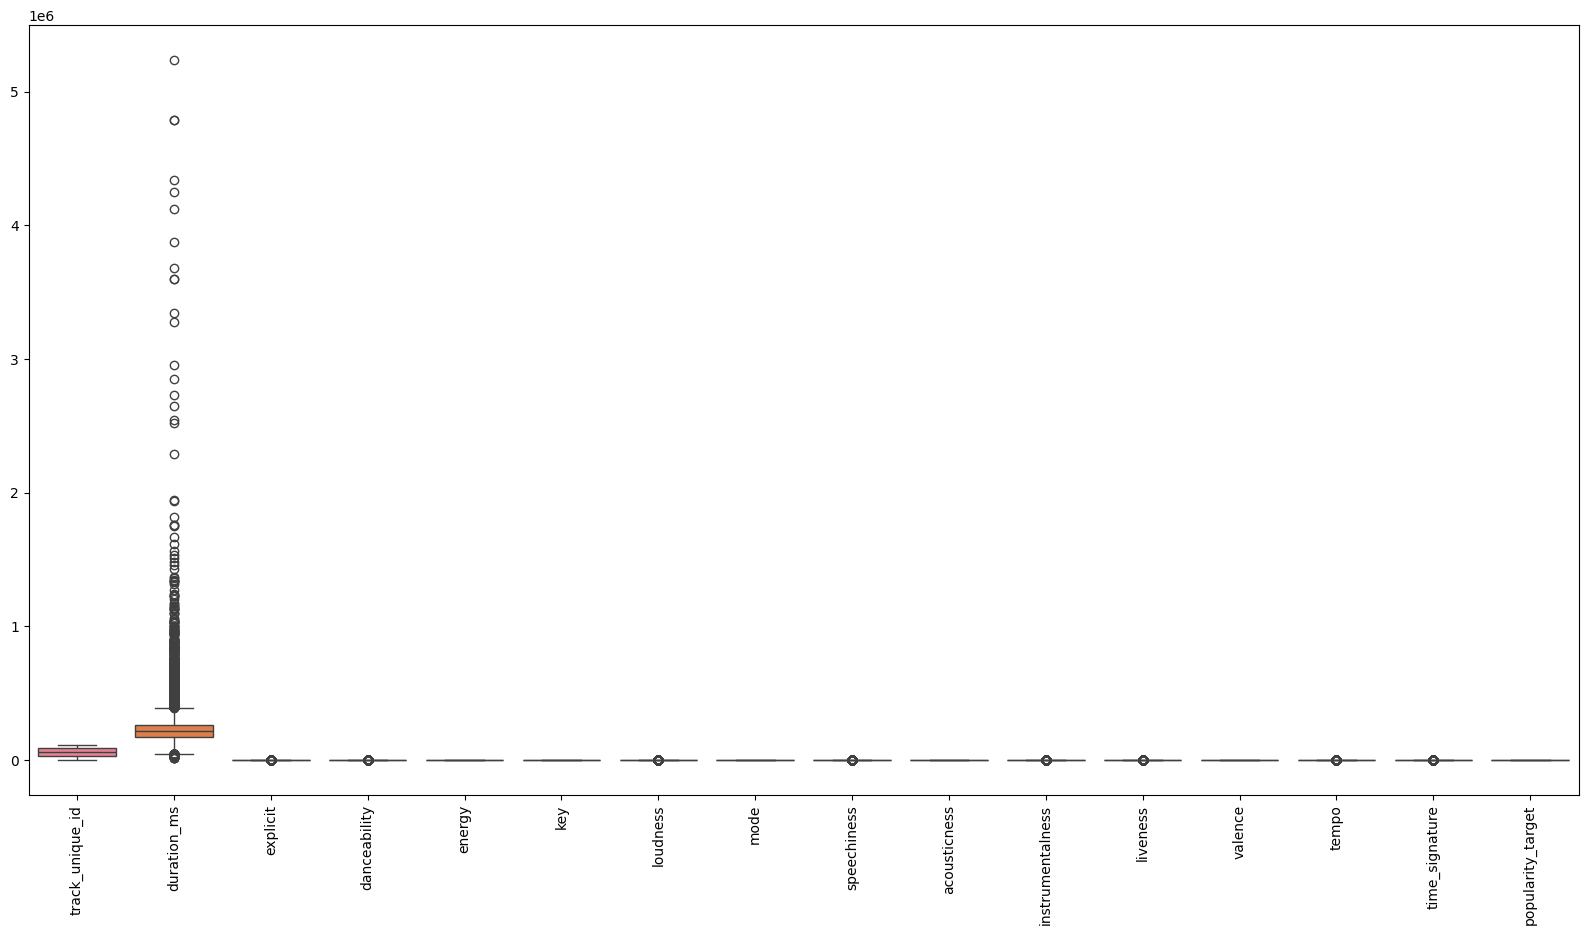

In [306]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

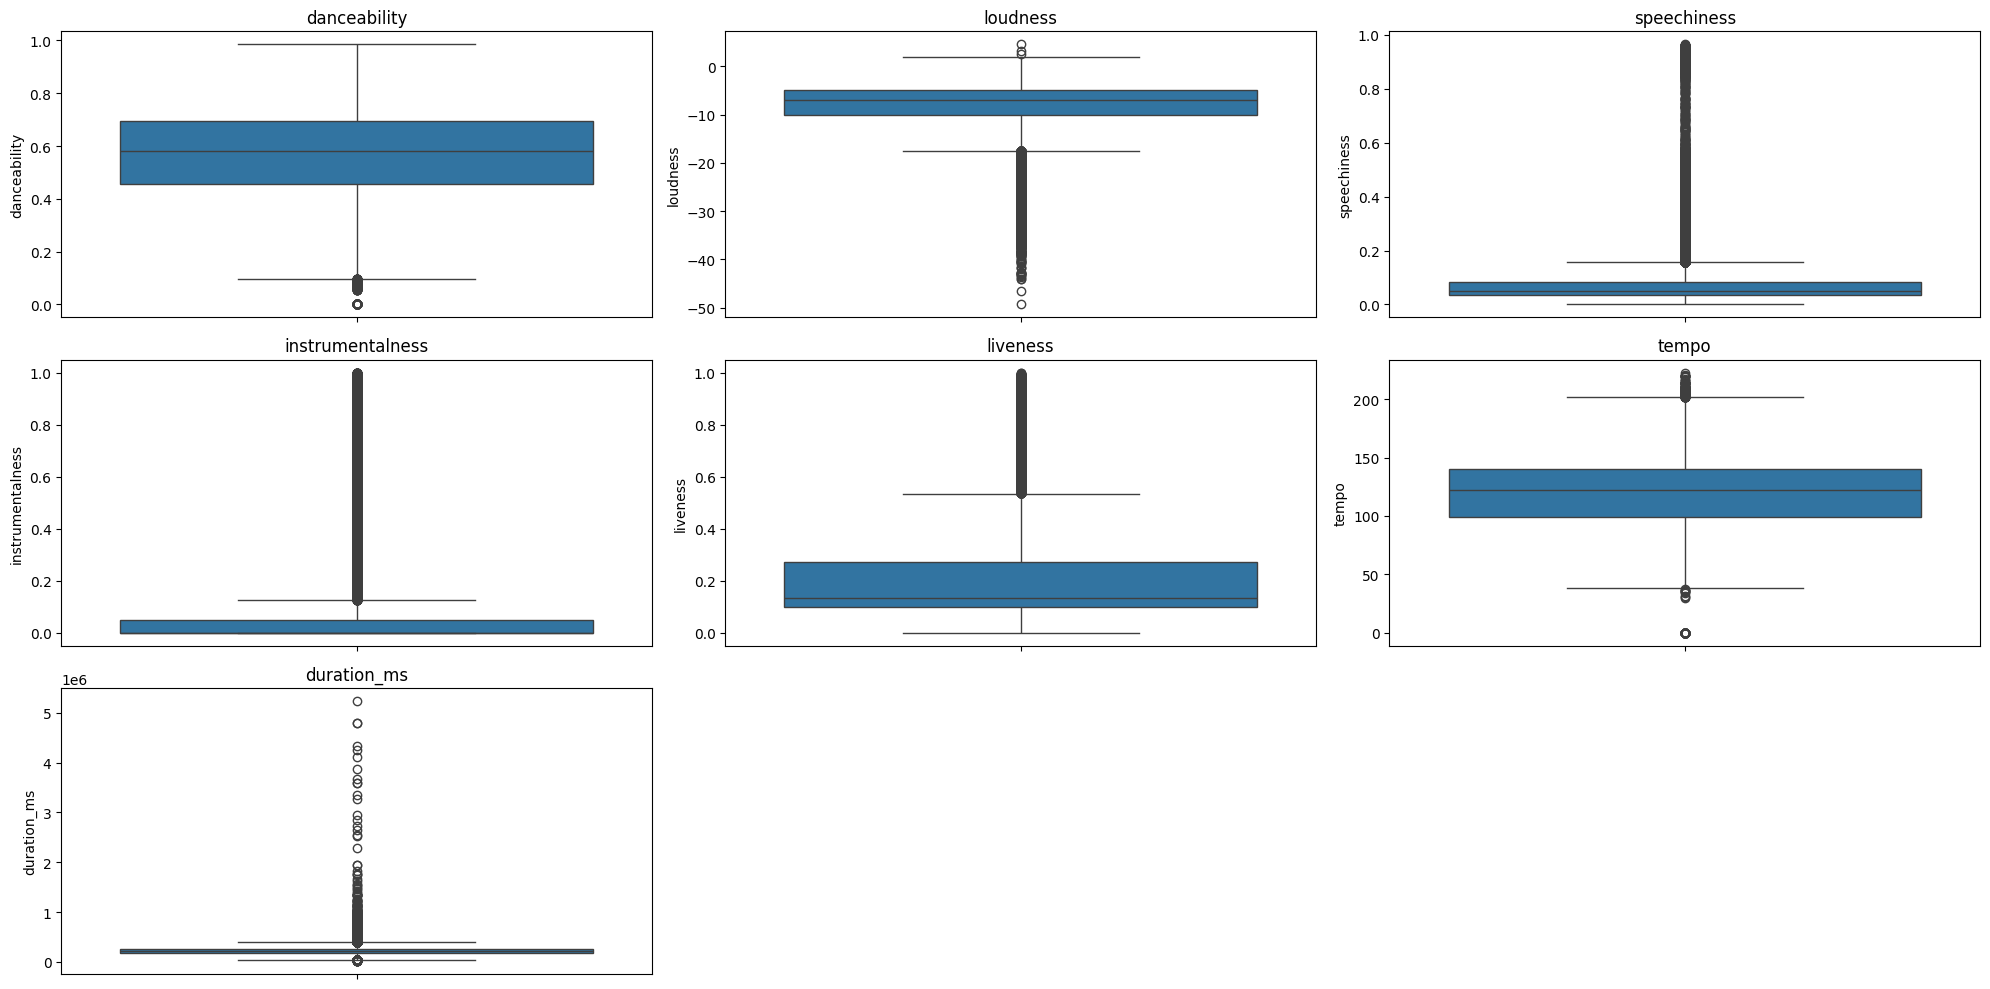

In [307]:
# Plotando todos os boxplots em gráficos separados em uma figura só
has_outliers = ['danceability', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms']
plt.figure(figsize=(20, 10))
for i, var in enumerate(has_outliers):
    plt.subplot(3, 3, i+1)
    sns.boxplot(df[var])
    plt.title(var)
plt.tight_layout()
plt.show()

Olhando para os gráficos, percebemos que nesse caso, os outliers são de dados relevantes para ajudar o modelo a descobrir se uma música será ou não popular, então não foi feita nenhuma remoção de outliers. Isso porque, se por exemplo considerarmos músicas maiores ou menores (em duração) que o IQR podem ser consideradas como músicas que fogem do padrão, no entanto, pode conter padrões que ajudem o modelo a prever se uma música será ou não popular.

- Verificando valores duplicados

In [308]:
print(df['track_unique_id'].count())
df.drop_duplicates(subset=['duration_ms', 'track_name', 'artists'], inplace=True)
print(df['track_unique_id'].count())

79800
61896


- Usando IsolationForest para remoção de outliers automaticamente

In [309]:
from sklearn.ensemble import IsolationForest

# Definir o modelo de Isolation Forest
iso_forest = IsolationForest(contamination=0.005, random_state=42)

# Ajustar o modelo e prever outliers
preds = iso_forest.fit_predict(df.select_dtypes(include=[np.number]))

# Manter apenas as linhas classificadas como normais (1)
df['outlier'] = preds
print(df['outlier'].value_counts())
df = df[df['outlier'] == 1]

outlier
 1    61586
-1      310
Name: count, dtype: int64


## Codificação de variáveis categóricas

Olhando para os dados e observando as descrições, foi possível identificar algumas variáveis categóricas como:

- Key (corresponde ao tom da música)
- Mode (Está em escala maior ou menor)
- Time Signature (Assinatura de tempo estimada da faixa (de 3 a 7))
- Gênero Musical
- Artista

Nas variáveis key e time signature a escolha foi pela codificação "One Hot Encoding", que transforma cada possibilidade em uma nova coluna no dataframe. Por exemplo, a coluna key será desaparecida e se transformará em key_0, key_1 e assim por diante.

A variável "mode" como só pode ser 0 e 1, já está no formato utilizável pelo modelo.

In [310]:
df['key_duplicate'] = df['key']
df['time_signature_duplicate'] = df['time_signature']
df = pd.get_dummies(df, columns=['key_duplicate', 'time_signature_duplicate'], prefix=['key', 'time_signature'])

- Transformando a coluna "Explicit" de verdadeiro/falso para 0 e 1

In [311]:
df['explicit'] = df['explicit'].astype(int)

## Engenharia de novas features

Um dos fatores mais relevantes para uma música ser considera popular ou não são os artistas que fizeram a música e o gênero que a música pertence. Levando em conta esses dois fatores, foi desenvolvido um algoritmo para criar uma probabilidade de sucesso com base nos dados de teste. Tanto para os gêneros, quanto para os artistas.

O algoritmo funciona da seguinte forma:

1. Pega cada artista e guarda em um objeto do python - os objetos em python são um conjunto de pares chave e valor, onde a chave deve ser única e por isso o nome dos artistas ou gêneros são armazenados lá



2. Para cada artista ele faz a verificação se o artista já existe no objeto, se existir ele soma um na chave musics_count e verifica também se a música do artista e/ou gênero é popular.



3. Pega esse objeto e converte para um dataframe

4. Pega o dataframe e cria uma nova coluna que é a divisão das músicas que foram popular, pelas músicas totais do artista. O mesmo é aplicável aos gêneros.

5. Pega o dataframe original dos dados e coloca a probabilidade calculada nos artistas da música. Essa probabilidade leva em conta duas coisas: A porcentagem de casos de sucesso e o quanto aquele artista/genero/album tem de música comparado a média de músicas de todos os artistas/gêneros/álbuns.

Aqui é importante ressaltar que, dentro desse algoritmo ele lida com o caso de ter mais de um artista participando de uma música, que olhando para a base de dados estão separados por ";". Exemplo: "artista1;artista2". Nesse caso, a probabilidade dos dois artistas é somado na probabilidade da música final.

In [312]:
def update_map(entity_map, entity, count_id, popularity_target):
    if entity not in entity_map:
        entity_map[entity] = {
            'id': count_id,
            'popularity_true': popularity_target if popularity_target == 1 else 0,
            'musics_count': 1
        }
        count_id += 1
    else:
        entity_map[entity]['popularity_true'] += popularity_target if popularity_target == 1 else 0
        entity_map[entity]['musics_count'] += 1
    return count_id

count_id = 0
count_id_genre = 0
count_id_album = 0
count_id_key = 0
count_time_signature = 0
genres_map = {}
artists_map = {}
albums_map = {}
keys_map = {}
time_signature_map = {}

for index, row in df.iterrows():
    artists_arr = row['artists'].split(";")
    df.at[index, 'artists_count'] = len(artists_arr)
    for artist in artists_arr:
        count_id = update_map(artists_map, artist, count_id, row['popularity_target'])
    
    count_id_genre = update_map(genres_map, row['track_genre'], count_id_genre, row['popularity_target'])
    count_id_key = update_map(keys_map, row['key'], count_id_key, row['popularity_target'])
    count_time_signature = update_map(time_signature_map, row['time_signature'], count_time_signature, row['popularity_target'])
    count_id_album = update_map(albums_map, row['album_name'], count_id_album, row['popularity_target'])

In [313]:
artists_df = pd.DataFrame(artists_map).T
artists_df['popularity_rate'] = (artists_df['popularity_true'] / artists_df['musics_count'])
artists_df.sort_values(by='popularity_rate', ascending=False)

,id,popularity_true,musics_count,popularity_rate
Dyrean,25248,1,1,1.0
State Champs,11190,1,1,1.0
Ebony,21314,2,2,1.0
Ikinya,21313,1,1,1.0
Kem,11066,1,1,1.0
...,...,...,...,...
梁釗峰,12890,0,1,0.0
Alif Tree,12891,0,1,0.0
Chuck Ragan,12905,0,2,0.0
Husky,12906,0,1,0.0


In [314]:
artists_df.head(50)

,id,popularity_true,musics_count,popularity_rate
Love and Rockets,0,0,1,0.000000
Filippa Giordano,1,0,8,0.000000
Susumu Yokota,2,5,16,0.312500
Franz Liszt,3,0,6,0.000000
YUNDI,4,0,1,0.000000
Scooter,5,9,109,0.082569
BTS,6,107,107,1.000000
Rosie Thomas,7,1,1,1.000000
The Shins,8,1,2,0.500000
Sufjan Stevens,9,9,10,0.900000


In [315]:
for index, row in df.iterrows():
    artists_arr = row['artists'].split(";")
    popularity_rate = 0
    count = 0
    for artist in artists_arr:
        popularity_rate += artists_df.loc[artist]['popularity_rate']
        count += 1
    
    df.at[index, 'artists_popularity_rate'] = popularity_rate / count

- Fazendo o mesmo do artista para o gênero

In [316]:
genres_df = pd.DataFrame(genres_map).T
genres_df['popularity_rate'] = (genres_df['popularity_true'] / genres_df['musics_count'])
genres_df.describe()

,id,popularity_true,musics_count,popularity_rate
count,114.000000,114.000000,114.000000,114.000000
mean,56.500000,269.666667,540.228070,0.527941
std,33.052988,172.086707,133.583094,0.307965
min,0.000000,0.000000,223.000000,0.000000
25%,28.250000,128.250000,462.000000,0.262625
50%,56.500000,255.500000,582.000000,0.534519
75%,84.750000,381.250000,649.250000,0.787469
max,113.000000,656.000000,715.000000,1.000000


In [317]:
genres_df.head(50)

,id,popularity_true,musics_count,popularity_rate
goth,0,111,599,0.185309
opera,1,102,637,0.160126
idm,2,60,643,0.093313
classical,3,57,506,0.112648
techno,4,330,502,0.657371
pop,5,328,406,0.807882
acoustic,6,408,624,0.653846
study,7,224,715,0.313287
trance,8,377,594,0.634680
progressive-house,9,471,535,0.880374


In [318]:
for index, row in df.iterrows():
    genres_arr = row['track_genre'].split(";")
    popularity_rate = 0
    for genre in genres_arr:
        popularity_rate += genres_df.loc[genre]['popularity_rate']
    df.at[index, 'genres_popularity_rate'] = popularity_rate

- Fazendo o mesmo do artista para o album

In [319]:
albums_df = pd.DataFrame(albums_map).T
albums_df['popularity_rate'] = (albums_df['popularity_true'] / albums_df['musics_count'])
albums_df.describe()

,id,popularity_true,musics_count,popularity_rate
count,36575.000000,36575.000000,36575.000000,36575.000000
mean,18287.000000,0.840519,1.683828,0.563425
std,10558.437384,1.200002,1.941605,0.486588
min,0.000000,0.000000,1.000000,0.000000
25%,9143.500000,0.000000,1.000000,0.000000
50%,18287.000000,1.000000,1.000000,1.000000
75%,27430.500000,1.000000,2.000000,1.000000
max,36574.000000,29.000000,76.000000,1.000000


Albuns com músicas explícitas podem ser mais populares? Para responder essa pergunta foi criada uma nova coluna que será visto a eficácia na matriz de correlação.

In [320]:
df_albums = df.groupby('album_name')
for index, row in df.iterrows():
    df.at[index, 'albums_explicit_rate'] = df_albums.get_group(row['album_name'])['explicit'].mean() 
    df.at[index, 'albums_popularity_rate'] = albums_df.loc[row['album_name']]['popularity_rate']

- Fazendo o mesmo para key e time signature

In [321]:
keys_df = pd.DataFrame(keys_map).T
keys_df['popularity_rate'] = (keys_df['popularity_true'] / keys_df['musics_count'])
keys_df.describe()

,id,popularity_true,musics_count,popularity_rate
count,12.000000,12.000000,12.000000,12.000000
mean,5.500000,2561.833333,5132.166667,0.501584
std,3.605551,739.131903,1552.204581,0.015046
min,0.000000,975.000000,1890.000000,0.486052
25%,2.750000,2086.500000,4146.750000,0.489883
50%,5.500000,2589.000000,5007.000000,0.498546
75%,8.250000,3077.000000,6267.000000,0.509240
max,11.000000,3537.000000,7277.000000,0.533455


In [322]:
keys_df.head(15)

,id,popularity_true,musics_count,popularity_rate
9,0,3018,6195,0.487167
7,1,3537,7277,0.486052
1,2,2841,5839,0.486556
8,3,1929,3722,0.518270
2,4,3254,6483,0.501928
6,5,2128,4197,0.507029
11,6,2623,4917,0.533455
0,7,3463,7056,0.490788
5,8,2457,4962,0.495163
4,9,2555,5052,0.505740


In [323]:
for index, row in df.iterrows():
    df.at[index, 'keys_popularity_rate'] = keys_df.loc[row['key']]['popularity_rate']

In [324]:
time_signature_df = pd.DataFrame(time_signature_map).T
time_signature_df['popularity_rate'] = (time_signature_df['popularity_true'] / time_signature_df['musics_count'])
time_signature_df.describe()

,id,popularity_true,musics_count,popularity_rate
count,5.000000,5.000000,5.000000,5.000000
mean,2.000000,6148.400000,12317.200000,0.427829
std,1.581139,12280.711474,23829.182984,0.073552
min,0.000000,2.000000,4.000000,0.358779
25%,1.000000,188.000000,524.000000,0.365421
50%,2.000000,391.000000,1070.000000,0.402652
75%,3.000000,2095.000000,5203.000000,0.500000
max,4.000000,28066.000000,54785.000000,0.512294


In [325]:
time_signature_df.head(15)

,id,popularity_true,musics_count,popularity_rate
4,0,28066,54785,0.512294
3,1,2095,5203,0.402652
5,2,391,1070,0.365421
1,3,188,524,0.358779
0,4,2,4,0.500000


In [326]:
for index, row in df.iterrows():
    df.at[index, 'time_signature_popularity_rate'] = time_signature_df.loc[row['time_signature']]['popularity_rate']

In [327]:
df['popularity_mean'] = (df['albums_popularity_rate'] + df['genres_popularity_rate'] + df['artists_popularity_rate']) / 3

Além disso, a combinação de outras features podem ser úteis para um modelo de classificação, abaixo estão algumas features combinadas

In [328]:
df['danceability_energy'] = df['danceability'] * df['energy']
df['loudness_energy'] = df['loudness'] * df['energy']
df['valence_tempo'] = df['valence'] * df['tempo']
df['duration_energy'] = df['duration_ms'] * df['energy']

- Danceability + Energy - Será que uma música "dançável" e enérgica tem mais probabilidade de ser popular?
- Loudness + Energy - Será que uma música mais alta e mais energética é mais popular?
- Valence + Tempo - Será que uma música mais feliz e mais rápida é mais popular?
- Duration + Energy - Será que uma música mais curta e mais energética é mais popular?

Essas features, podem ser úteis futuramente para aumentar a acurácia do modelo preditivo.

## Análise dos dados

### Matriz de correlação

Primeiro, uma matriz de correlação foi realizada para observar o quão os dados estão relacionados com o alvo da popularidade

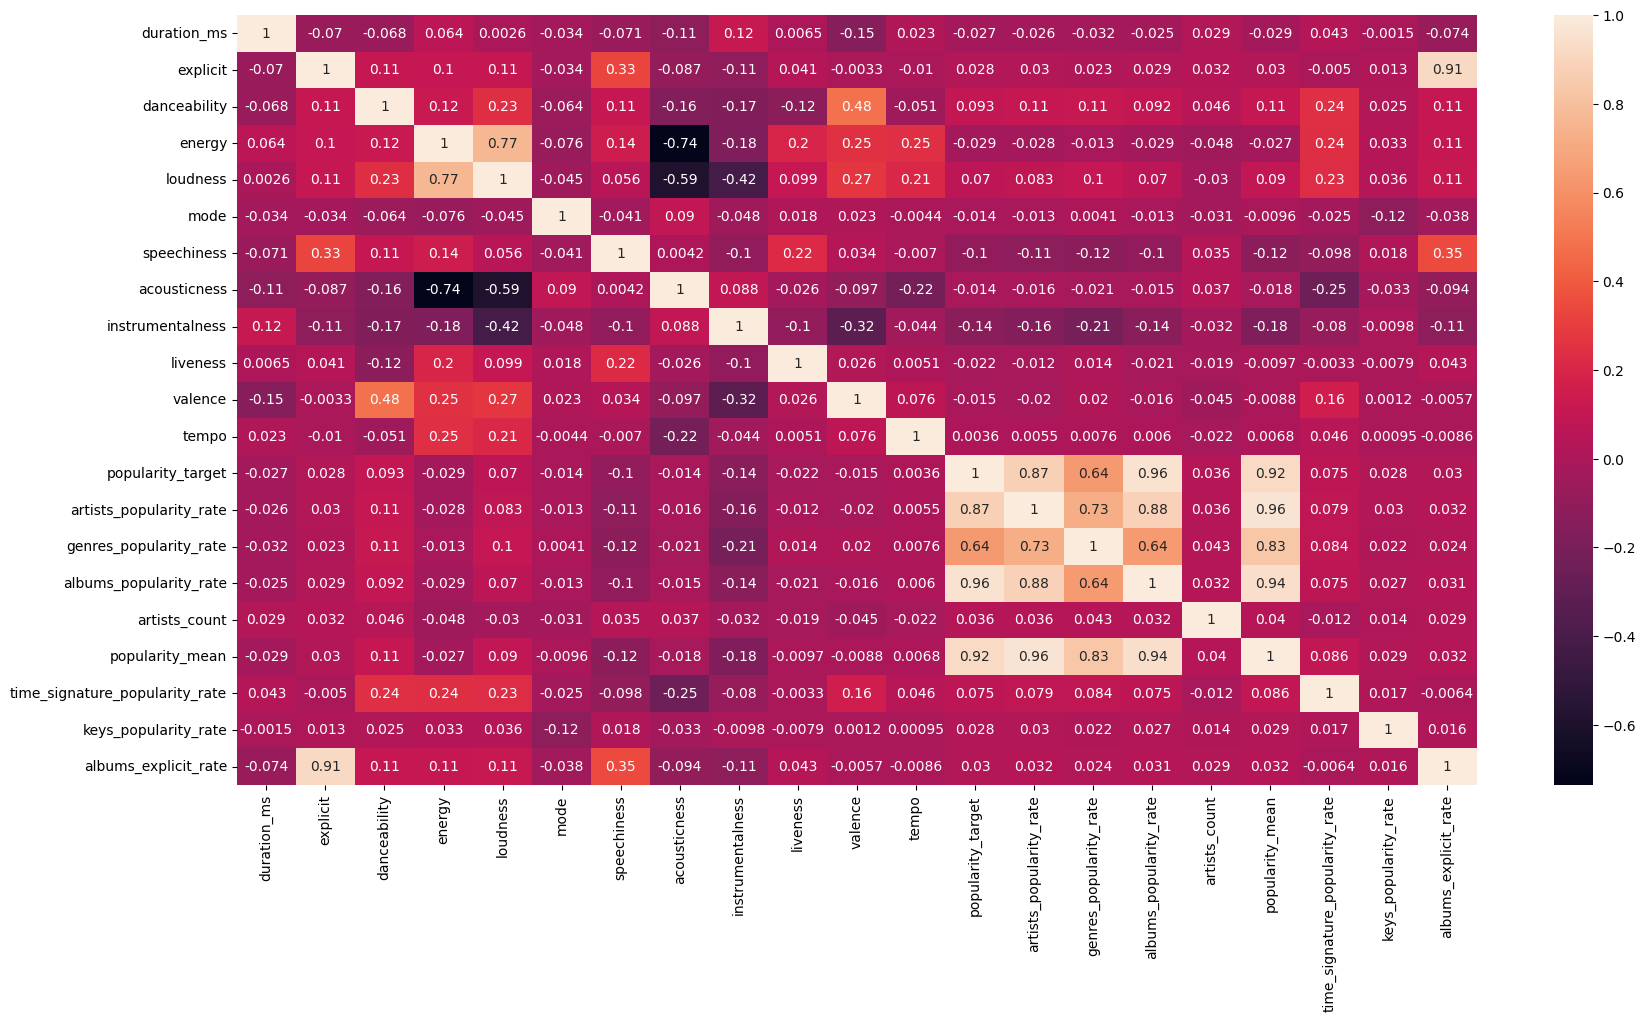

In [329]:
correlation_matrix = df[['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity_target', 'artists_popularity_rate', 'genres_popularity_rate', 'albums_popularity_rate', 'artists_count', 'popularity_mean', 'time_signature_popularity_rate', 'keys_popularity_rate', 'albums_explicit_rate']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Com isso, foi possível observar que os dados originais não tem muita correlação com a coluna alvo (popularity_target), possivelmente então, o modelo conseguiria descobrir se uma música será popular ou não pelo conjunto de variáveis musicais. Apesar disso, as duas variáveis criadas, com a popularidade do artista e do gênero, tem uma grande influência em definir se uma música é popular ou não, o que comprova o ponto citado anteriormente.

### Histogramas de distribuição

Aqui, foi criado uma série de histogramas de distribuição separadas em músicas populares e não populares para ver a frequência nas duas classificações diferentes.

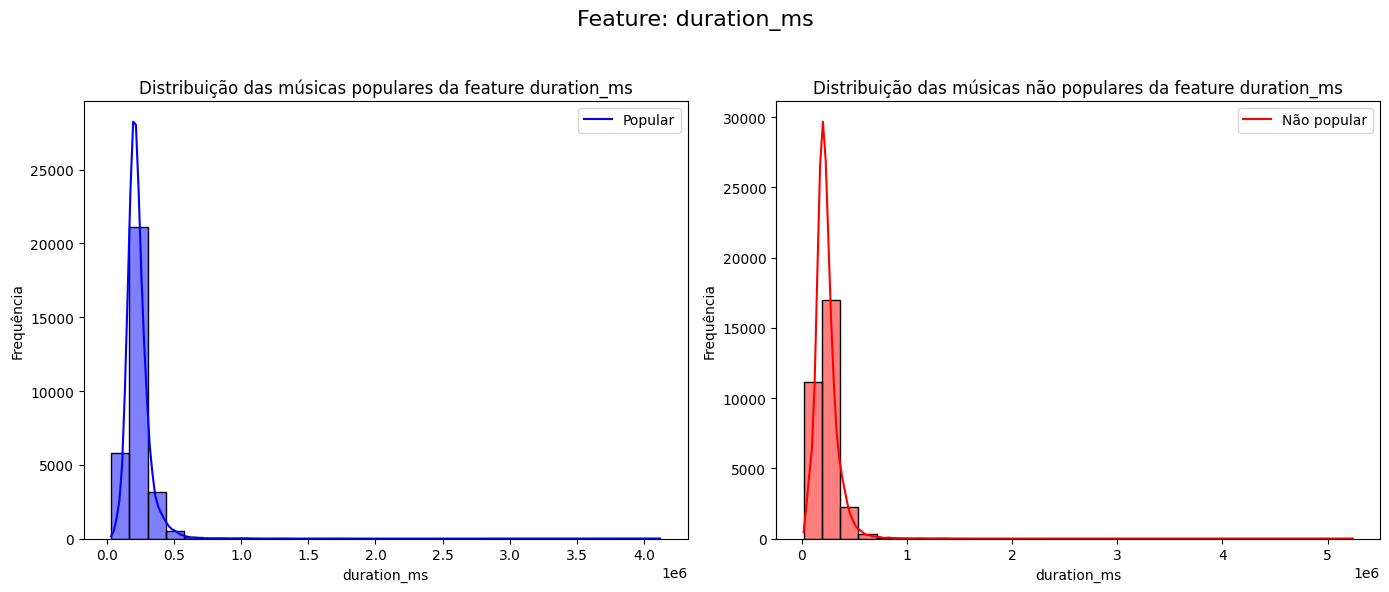

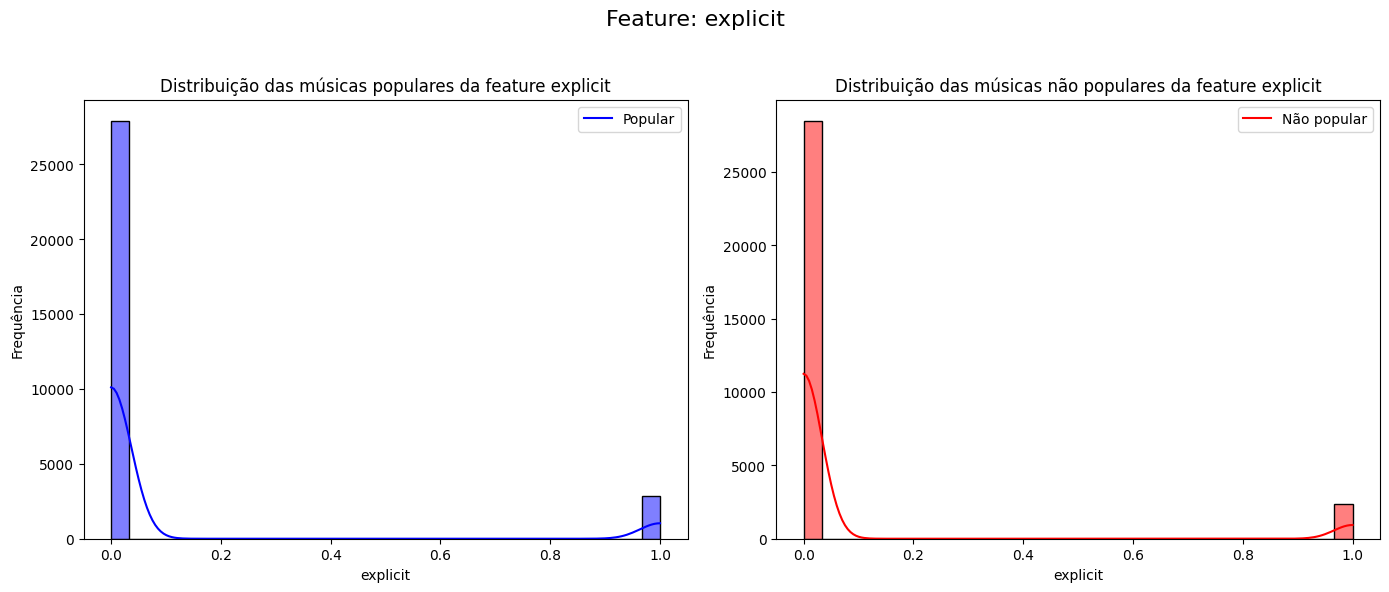

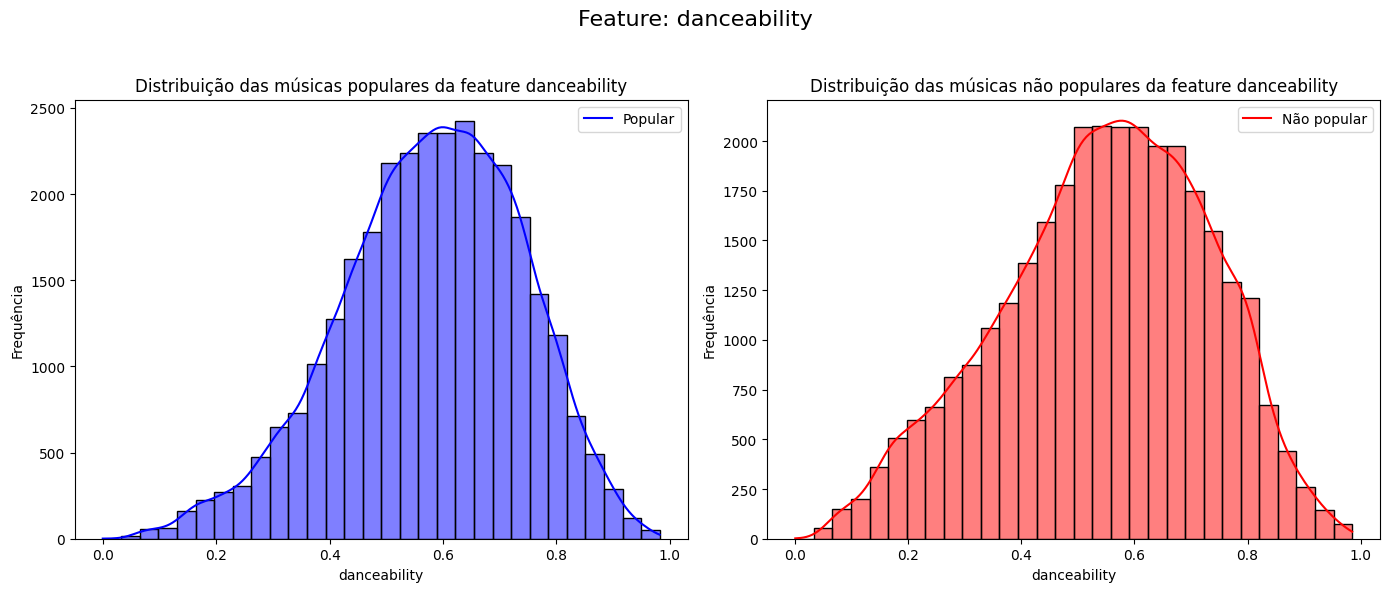

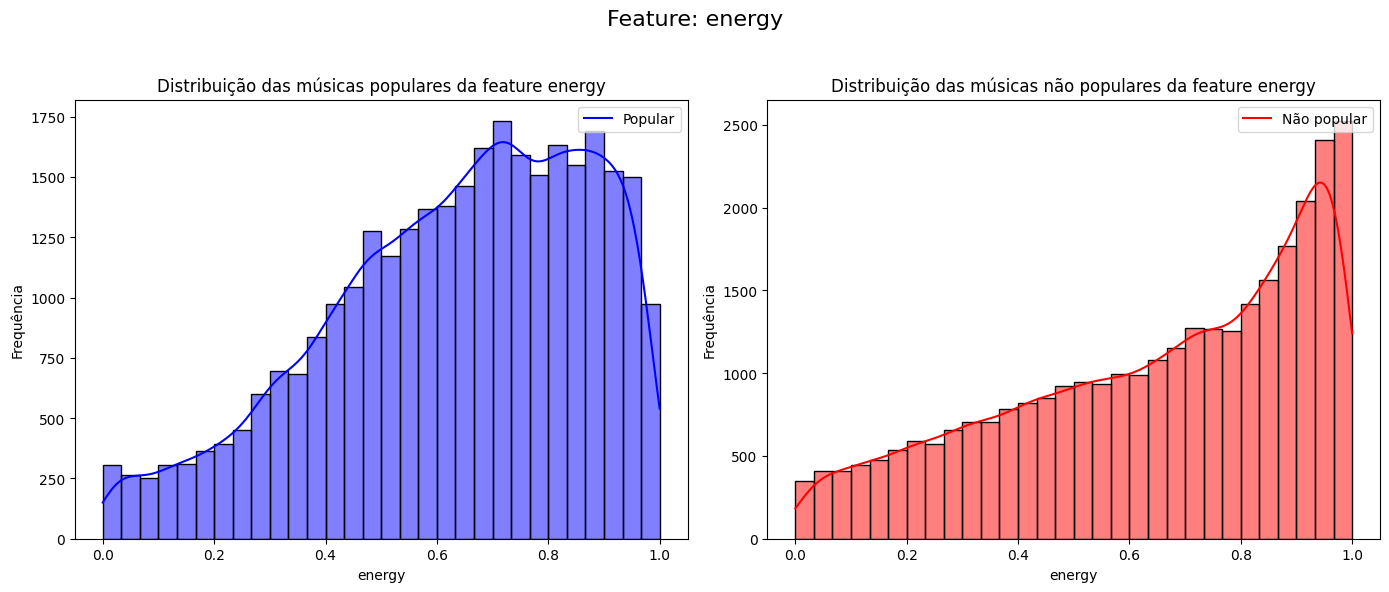

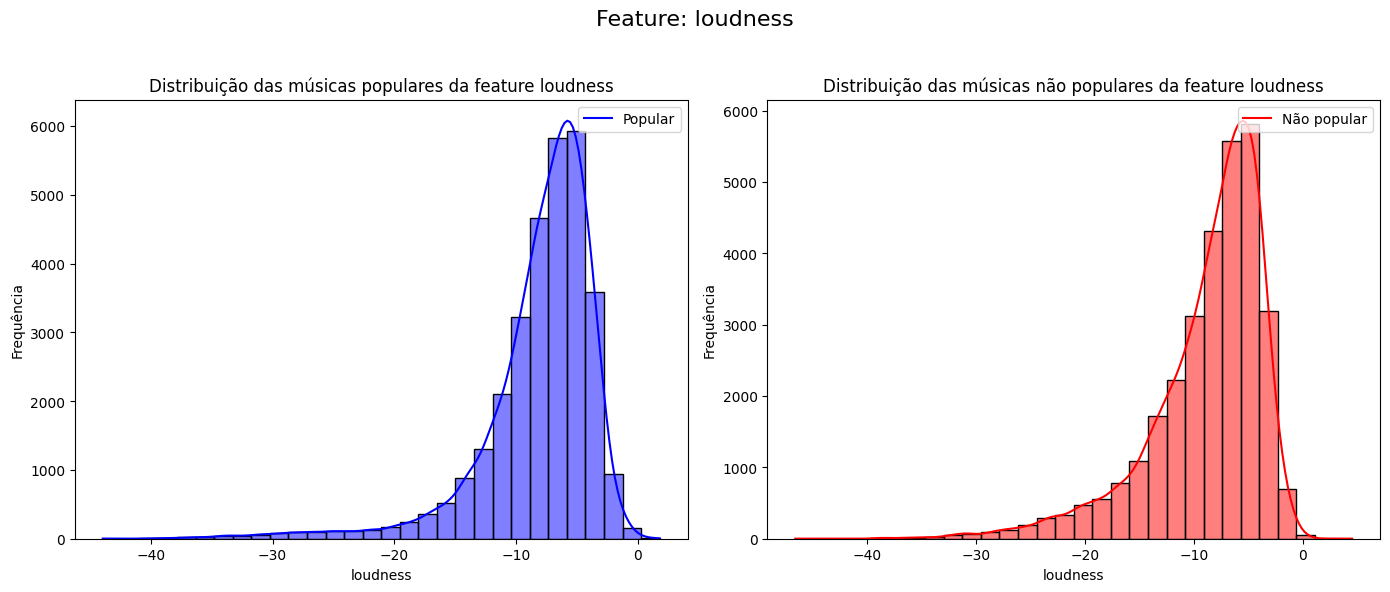

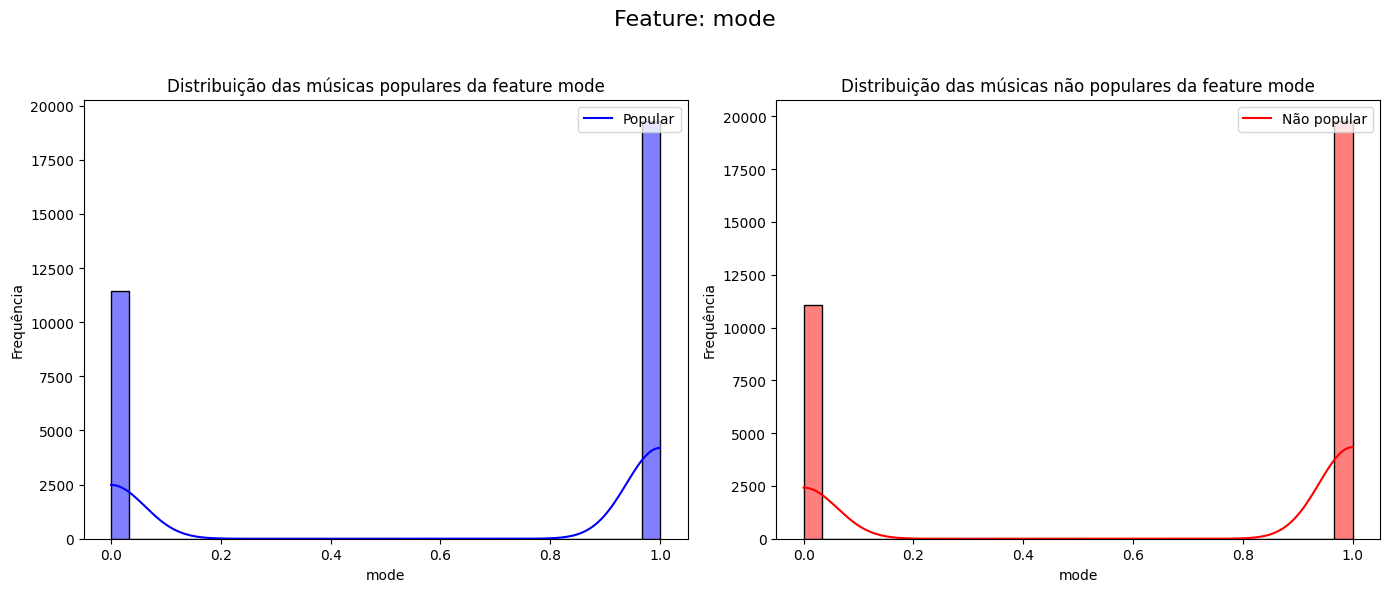

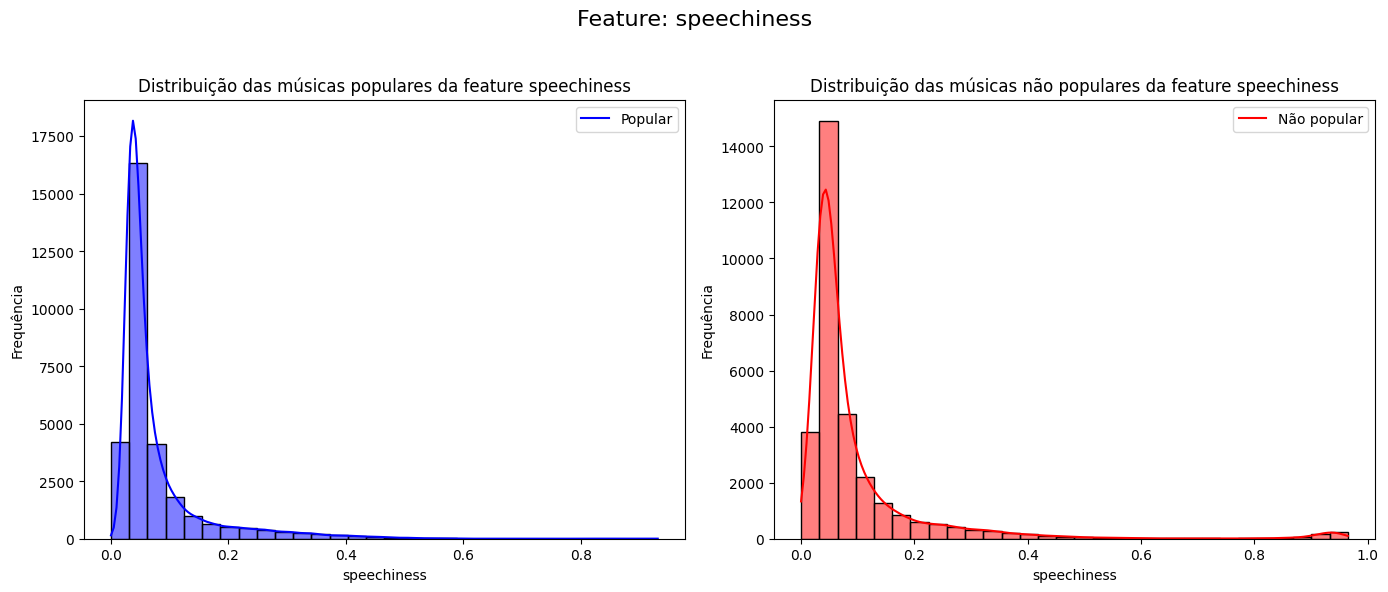

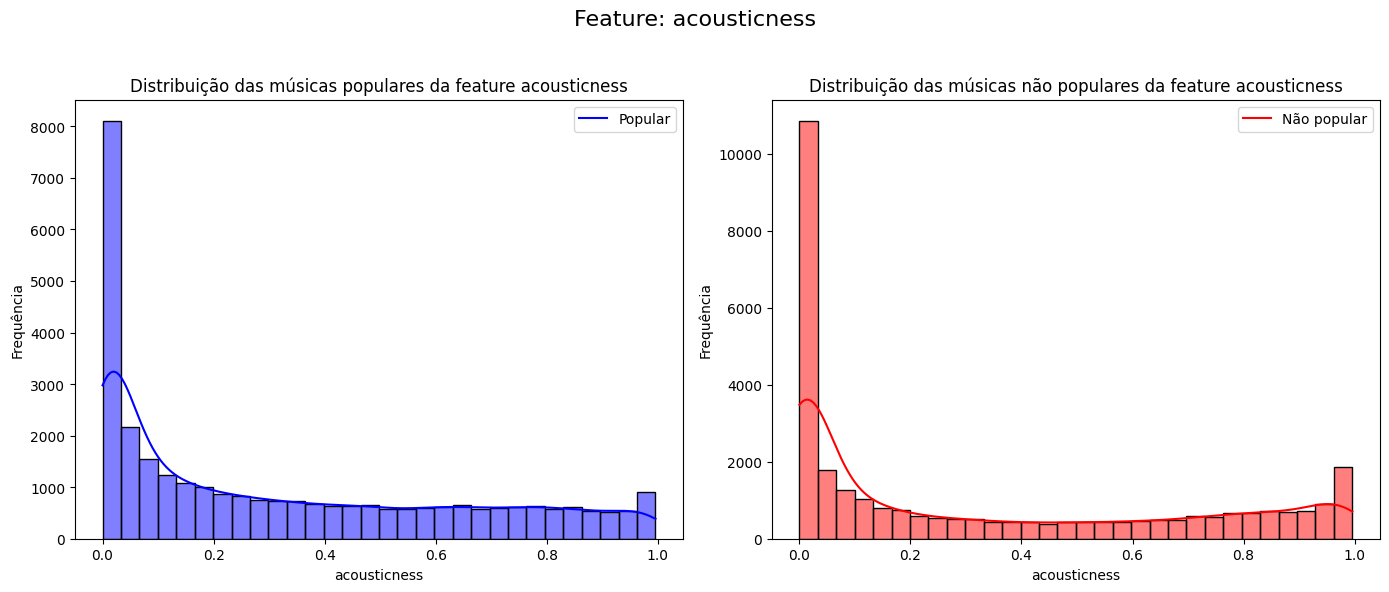

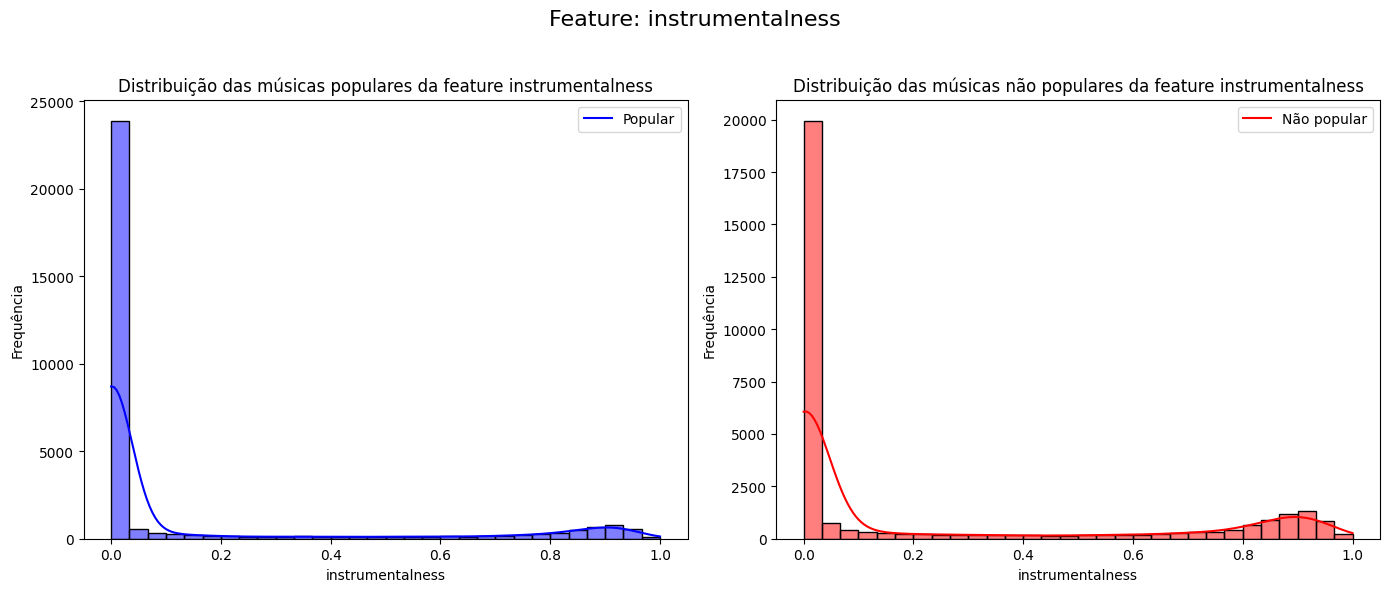

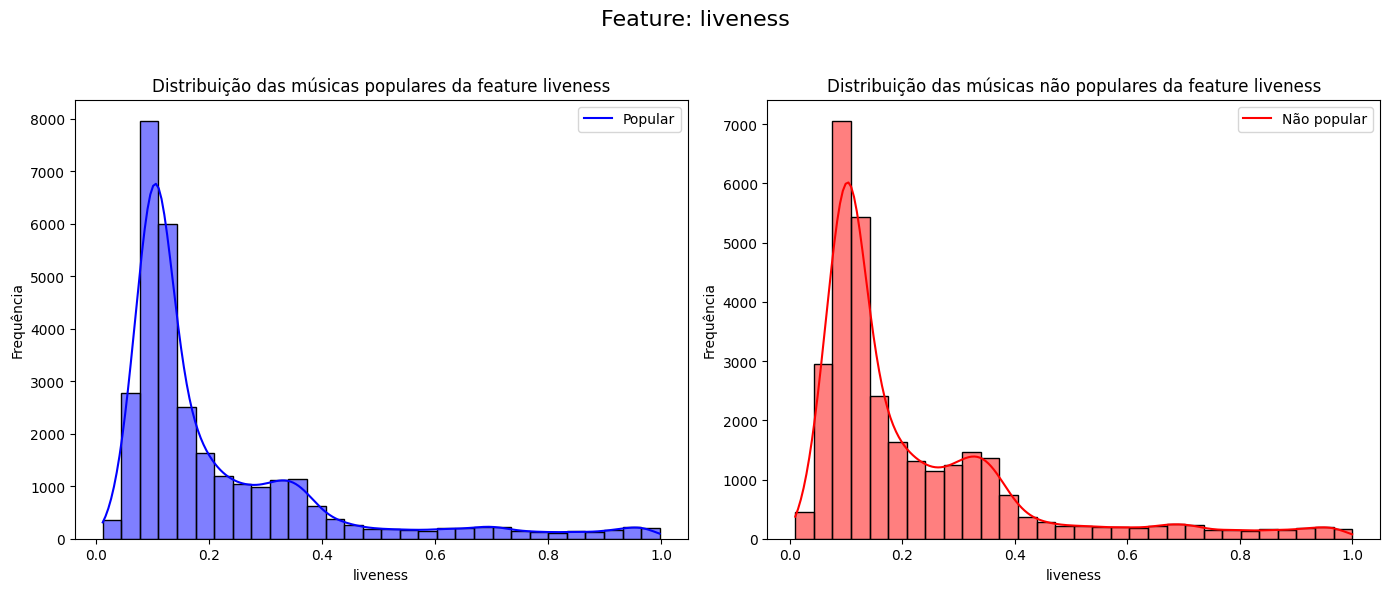

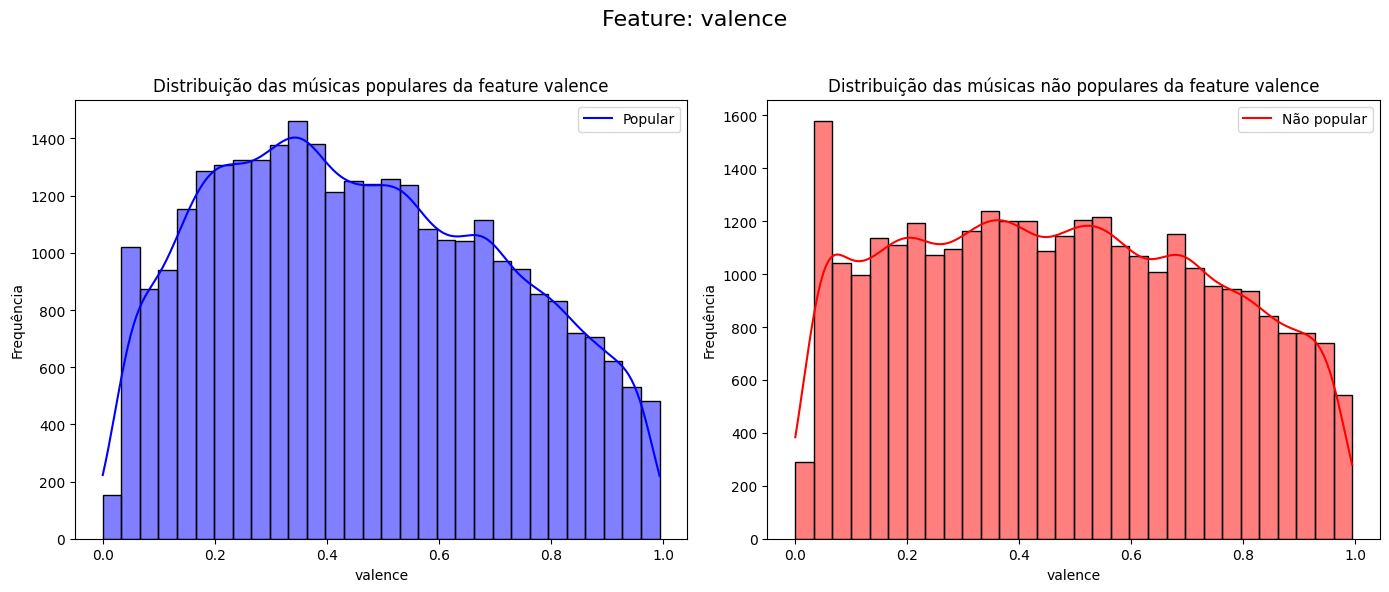

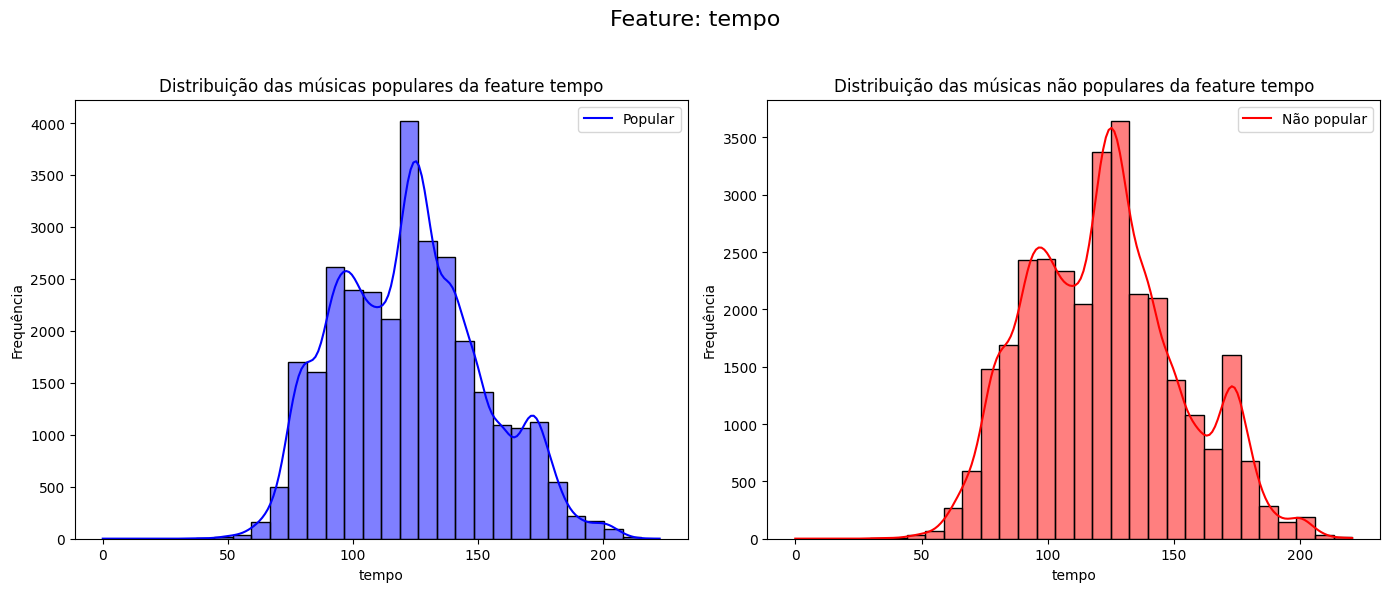

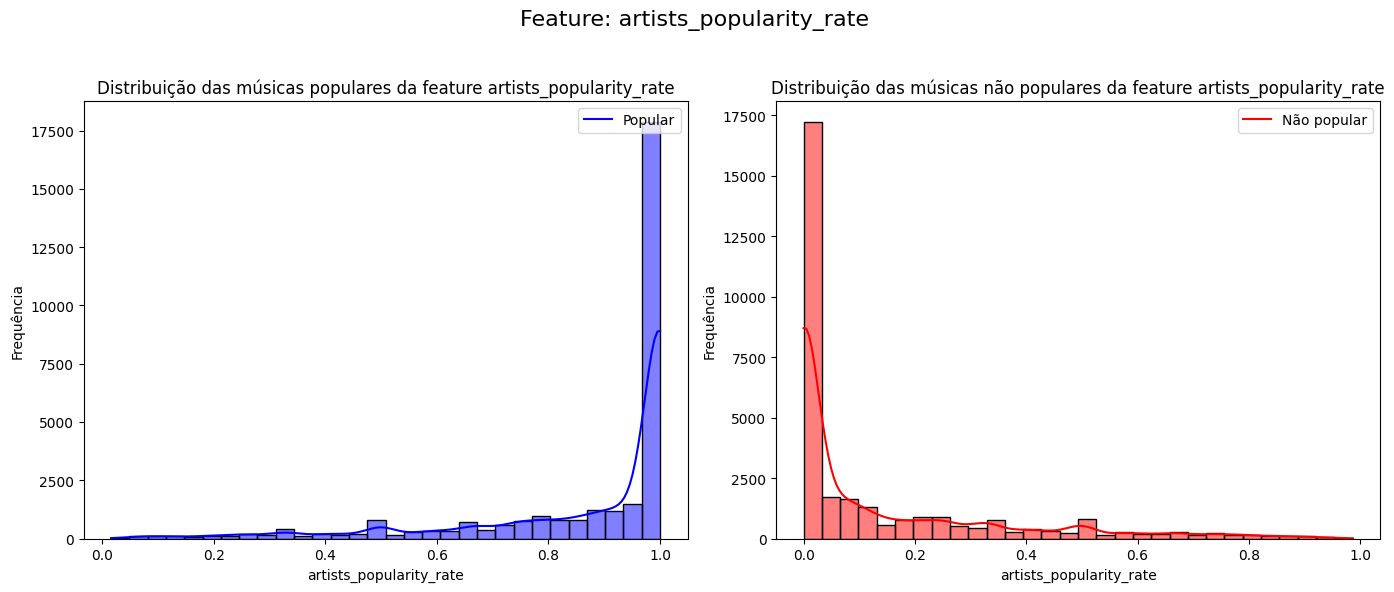

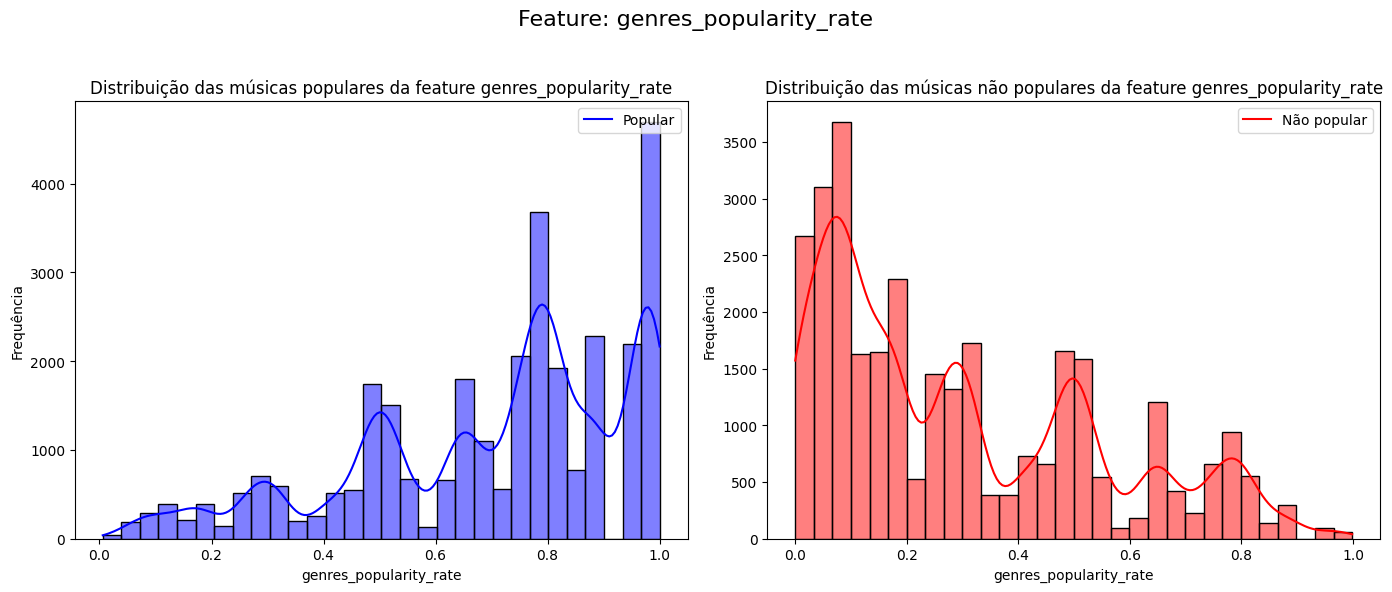

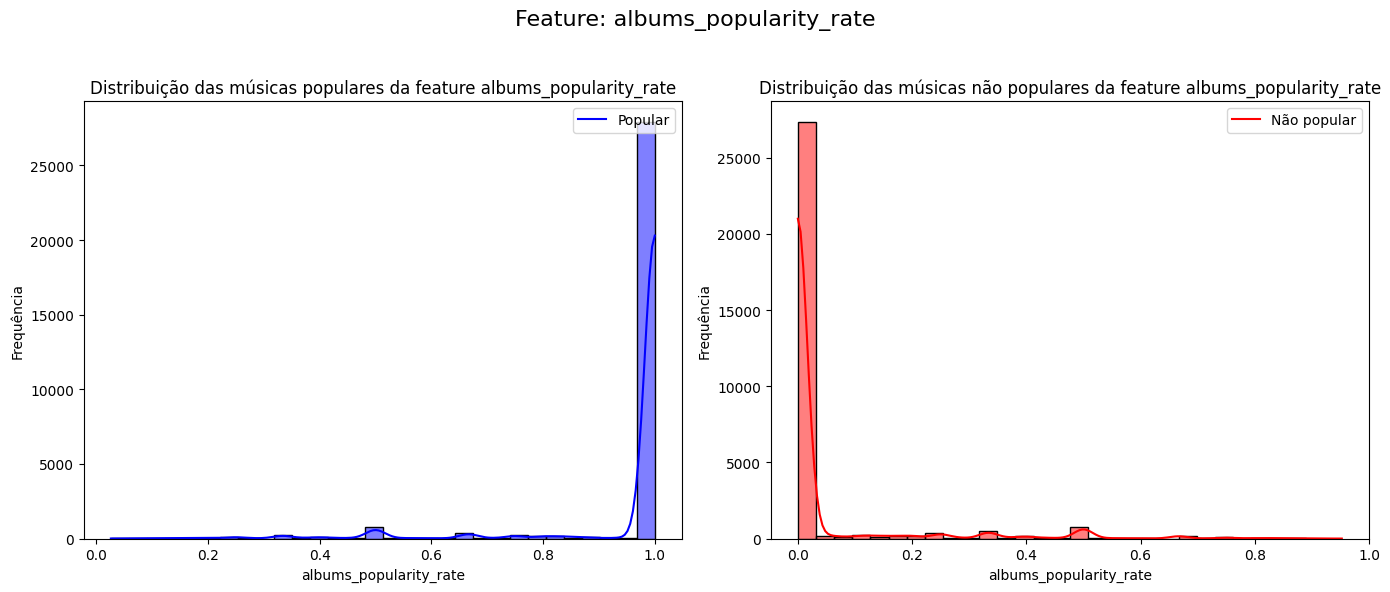

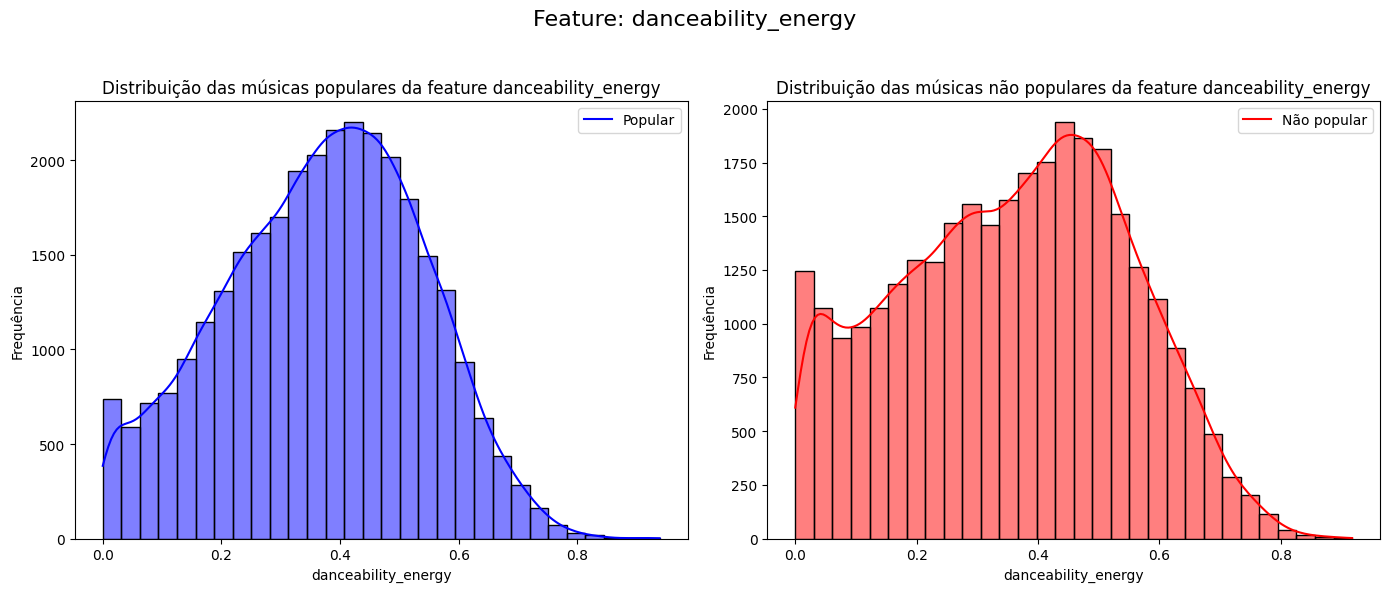

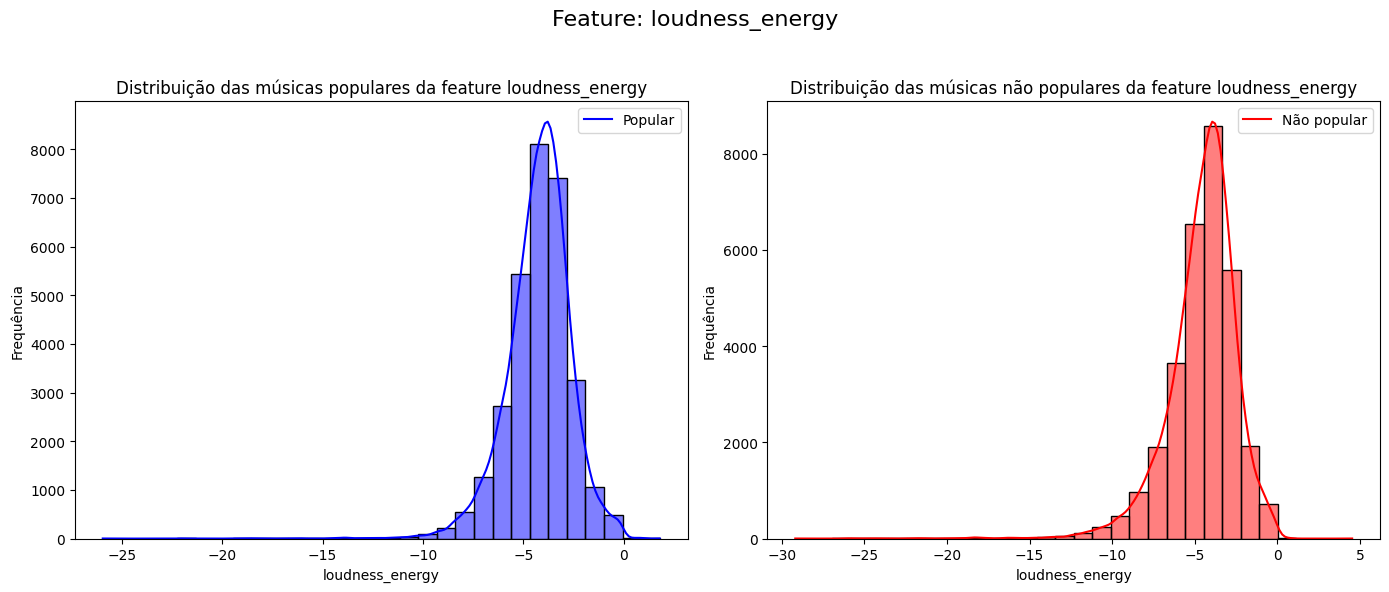

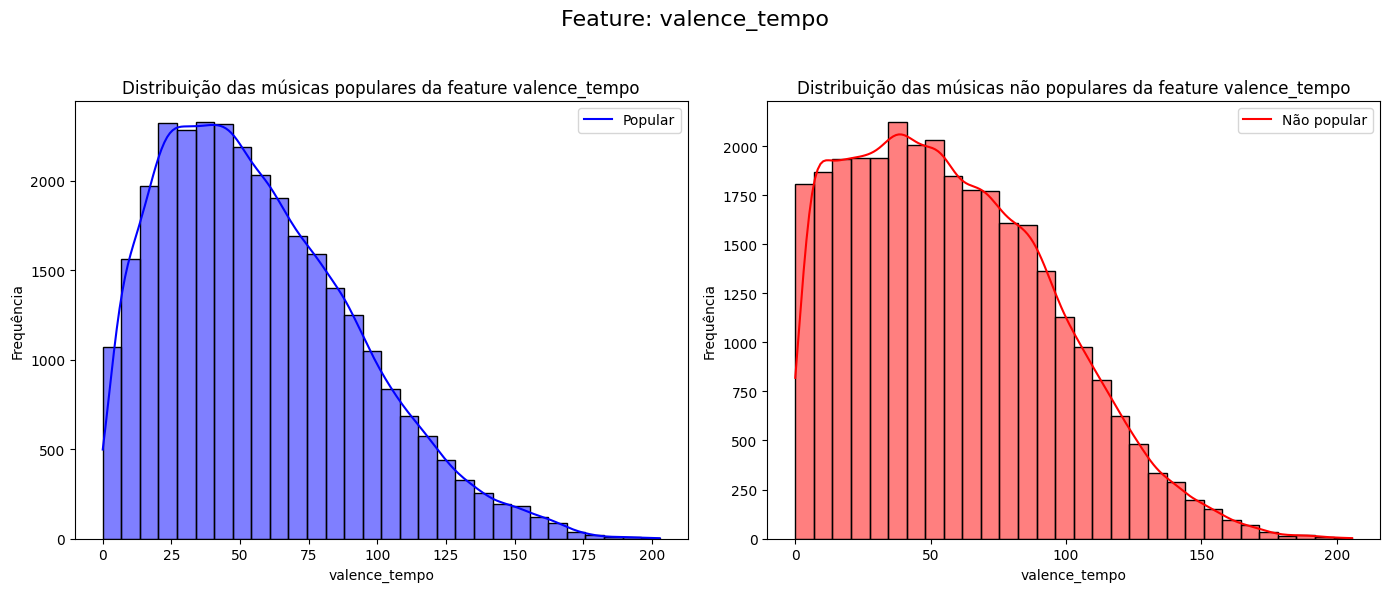

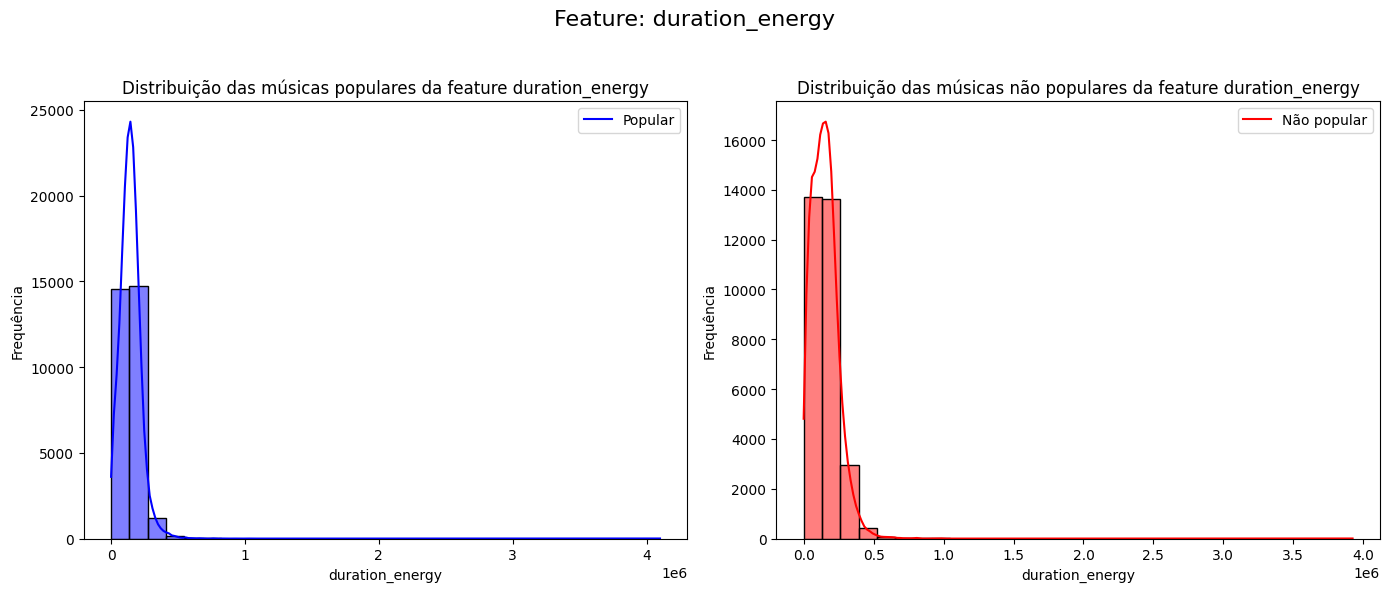

In [330]:
popular_tracks = df[df['popularity_target'] == 1]
non_popular_tracks = df[df['popularity_target'] == 0]

features = ['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'artists_popularity_rate', 'genres_popularity_rate', 'albums_popularity_rate', 'danceability_energy', 'loudness_energy', 'valence_tempo', 'duration_energy']

for feature in features:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    sns.histplot(popular_tracks[feature], bins=30, kde=True, ax=ax[0], color='blue')
    ax[0].set_title(f'Distribuição das músicas populares da feature {feature}')
    ax[0].set_xlabel(feature)
    ax[0].set_ylabel('Frequência')
    ax[0].legend(['Popular'], loc='upper right')
    
    sns.histplot(non_popular_tracks[feature], bins=30, kde=True, ax=ax[1], color='red')
    ax[1].set_title(f'Distribuição das músicas não populares da feature {feature}')
    ax[1].set_xlabel(feature)
    ax[1].set_ylabel('Frequência')
    ax[1].legend(['Não popular'], loc='upper right')
    
    fig.suptitle(f"Feature: {feature}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Com os histogramas, conseguimos observar que as músicas populares ou não populares não tem um padrão estabelecido, e que na verdade, elas seguem um padrão das músicas de modo geral, toda a população, seja popular ou não, segue quase que uma mesma distribuição.

As duas variáveis que explicitamente tem nitidamente correlação com a popularidade olhando para o histograma e para a matriz de correlação, foram as duas variáveis criadas ("artista popularity rate" e "genre popularity rate").

- Usando o pairplot do seaborn (plota gráficos entre todas as variáveis)

In [331]:
# Código estará escondidado porque demora muito para rodar, então caso queira, só descomentar

# features = ['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# sns.pairplot(df, hue='popularity_target', vars=features, diag_kind='kde')

## Formulação de hipóteses

**1. A escolha do gênero musical influencia na popularidade da música**

Justificativa: Certos gêneros musicais tendem a ter maior apelo junto a um público específico ou mais amplo. Gêneros como pop, rap, ou música eletrônica têm uma presença massiva nas plataformas de streaming, enquanto outros gêneros, como música clássica ou experimental, podem atrair um nicho menor.

**2. O(s) artista(s) influenciam na popularidade de uma música**

Justificativa: Não só os gêneros, como os artistas tendem a ter uma maior base de fãs e/ou um público específico que influenciam na popularidade da música. Casos de sucesso como o The Beatles, podem atingir um público maior facilmente comparado à um cantor que ainda não tem influência no mundo da música. Vale ressaltar que o objetivo é encontrar novos hits no Spotify, não encontrar cantores novos que podem fazer sucesso, por este motivo, essa hipótese está sendo levantada.

**3. O conjunto de características musicais podem contribuir para a popularidade de uma música**

Justificativa: Apesar de todas as colunas originais e numéricas terem uma correlação baixa com o alvo (popularity_target), o conjunto das características musicais podem ajudar o modelo preditivo a identificar padrões sutis nas popularidade de uma música, ou seja, não olhar apenas para uma variável individualmente, mas para como o modelo pode trabalhar com o conjunto delas.

**4. A popularidade de um album influencia na popularidade de uma música**

Justificação: Assim como os artistas e gêneros, os álbuns também tem uma influência na popularidade de uma música. Álbuns de sucesso tendem a ter músicas de sucesso, e músicas de sucesso tendem a estar em álbuns de sucesso. Por isso, a popularidade de um álbum pode ser um fator relevante para a popularidade de uma música.


As hipóteses levantadas serão testadas ao longo do projeto, e a partir dos resultados obtidos, será possível validar ou refutar cada uma delas.

## Seleção de features

A seleção de features foi feita com base na matriz de correlação e nas hipóteses levantadas. As features selecionadas foram:

In [332]:
features = ['artists_popularity_rate', 'danceability', 'energy',
            'speechiness', 'instrumentalness', 'liveness',
            'explicit', 'duration_ms', 'loudness', 'time_signature_popularity_rate',
            'genres_popularity_rate', 'albums_popularity_rate']

**As escolhas se basearam principalmente em quatro pilares: as hipóteses levantadas, a matriz de correlação, tentativa e erro de acurácia e a engenharia de novas features.**

## Padronização dos dados

O último passo antes de treinar o modelo é padronizar os dados, ou seja, colocar todas as variáveis na mesma escala. Para isso, foi utilizado o MinMaxScaler do sklearn. Isso é importante para que o modelo não dê mais importância para uma variável que tenha uma escala maior do que outra.

In [333]:
scaler = MinMaxScaler()

In [334]:
df[['duration_ms', 'tempo', 'artists_popularity_rate', 'genres_popularity_rate', 'albums_popularity_rate', 'popularity_mean', 'time_signature_popularity_rate', 'keys_popularity_rate']] = scaler.fit_transform(df[['duration_ms', 'tempo', 'artists_popularity_rate', 'genres_popularity_rate', 'albums_popularity_rate', 'popularity_mean', 'time_signature_popularity_rate', 'keys_popularity_rate']])

## Preparação dos dados para o modelo

In [335]:
X = df[features]
y = df['popularity_target']

## Sampling dos dados

Para um modelo de classificação é importante que as classes estejam balanceadas, para não ocorrer problema de overfitting no modelo. Ou ela ficar somente boa em adivinhar uma classe apenas

In [336]:
df['popularity_target'].value_counts()

popularity_target
0    30844
1    30742
Name: count, dtype: int64

As classes estão bem distribuídas e portanto, um oversampling dos dados não se faz necessário.

## Dividindo os dados de treino

Realizando a divisão dos dados de treino em 80% para treino e 20% para ver como está a acurácia do modelo preditivo.

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Treinando o modelo

### Treinando o modelo 1 - Random Forest

In [338]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

# Previsões e acurácia
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Random Forest: {rf_accuracy:.4f}")

# Matriz de confusão e relatório de classificação
print("Matriz de Confusão - Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("Relatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf))

Acurácia do Random Forest: 0.9769
Matriz de Confusão - Random Forest:
[[6080  120]
 [ 164 5954]]
Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6200
           1       0.98      0.97      0.98      6118

    accuracy                           0.98     12318
   macro avg       0.98      0.98      0.98     12318
weighted avg       0.98      0.98      0.98     12318



### Avaliação completa do modelo 1

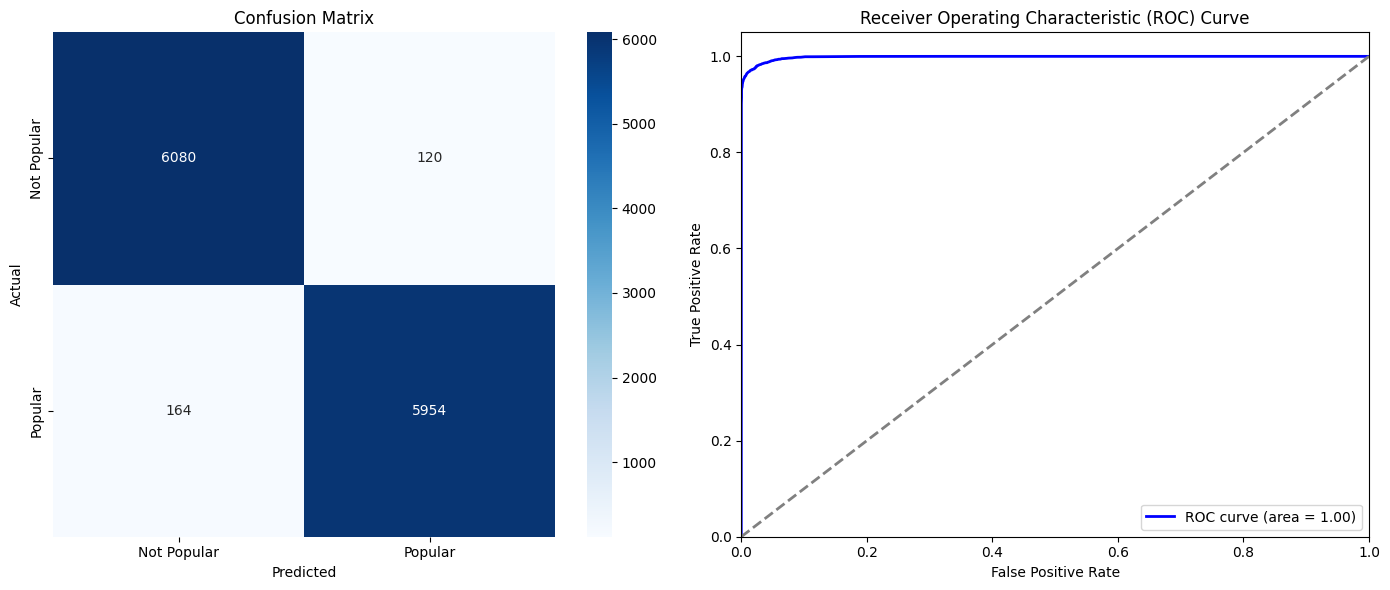

In [339]:
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)
fpr, tpr, _ = roc_curve(y_test, y_pred_rf_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 6))

# Matriz de Confusão
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Treinando o modelo 2 - Gradient Boosting

In [340]:
gcb = GradientBoostingClassifier(n_estimators=100, random_state=0)
gcb.fit(X_train, y_train)

# Previsões e acurácia
y_pred_gcb = gcb.predict(X_test)
gcb_accuracy = accuracy_score(y_test, y_pred_gcb)
print(f"Acurácia do Gradient Boosting: {gcb_accuracy:.4f}")

# Matriz de confusão e relatório de classificação
print("Matriz de Confusão - Gradient Boosting:")
print(confusion_matrix(y_test, y_pred_gcb))
print("Relatório de Classificação - Gradient Boosting:")
print(classification_report(y_test, y_pred_gcb))

Acurácia do Gradient Boosting: 0.9774
Matriz de Confusão - Gradient Boosting:
[[6086  114]
 [ 165 5953]]
Relatório de Classificação - Gradient Boosting:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6200
           1       0.98      0.97      0.98      6118

    accuracy                           0.98     12318
   macro avg       0.98      0.98      0.98     12318
weighted avg       0.98      0.98      0.98     12318



### Avaliação completa do modelo 2

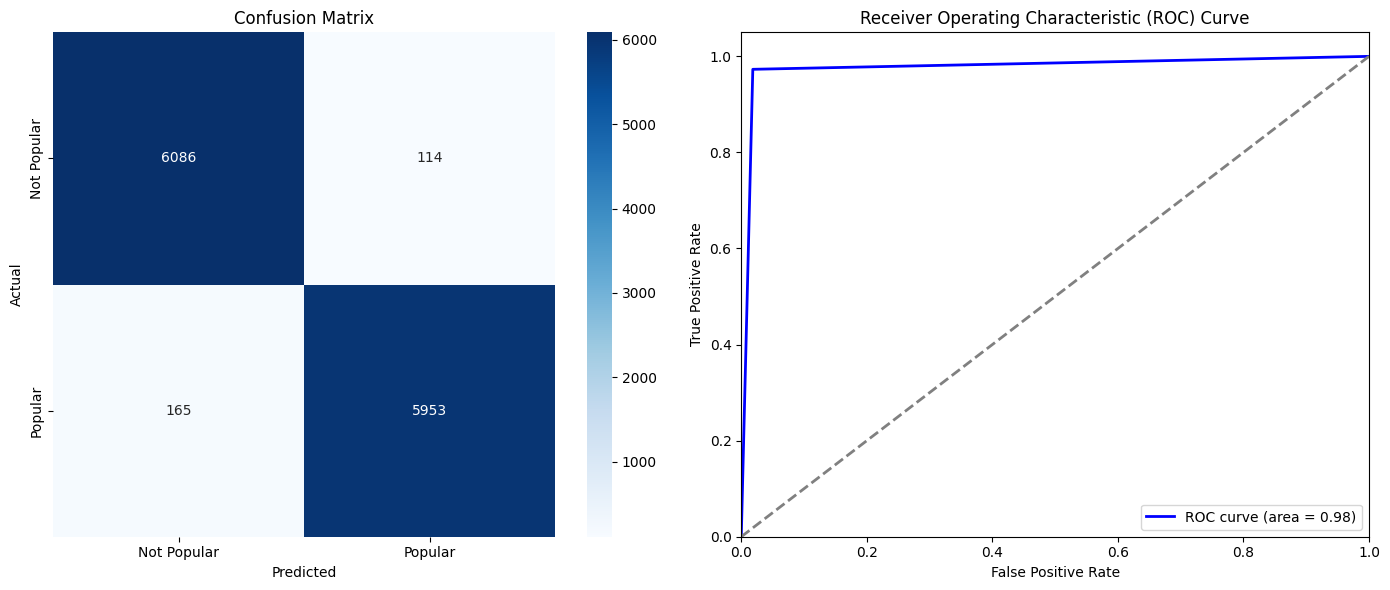

In [341]:
accuracy = accuracy_score(y_test, y_pred_gcb)
conf_matrix = confusion_matrix(y_test, y_pred_gcb)
class_report = classification_report(y_test, y_pred_gcb)
fpr, tpr, _ = roc_curve(y_test, y_pred_gcb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 6))

# Matriz de Confusão
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Treinando o modelo 3 - Extra Trees

In [342]:
etc = ExtraTreesClassifier(n_estimators=100, random_state=0)
etc.fit(X_train, y_train)

# Previsões e acurácia
y_pred_etc = etc.predict(X_test)
etc_accuracy = accuracy_score(y_test, y_pred_etc)
print(f"Acurácia do Extra Trees: {etc_accuracy:.4f}")

# Matriz de confusão e relatório de classificação
print("Matriz de Confusão - Extra Trees:")
print(confusion_matrix(y_test, y_pred_etc))
print("Relatório de Classificação - Extra Trees:")
print(classification_report(y_test, y_pred_etc))

Acurácia do Extra Trees: 0.9769
Matriz de Confusão - Extra Trees:
[[6086  114]
 [ 170 5948]]
Relatório de Classificação - Extra Trees:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6200
           1       0.98      0.97      0.98      6118

    accuracy                           0.98     12318
   macro avg       0.98      0.98      0.98     12318
weighted avg       0.98      0.98      0.98     12318



### Avaliação completa do modelo 3

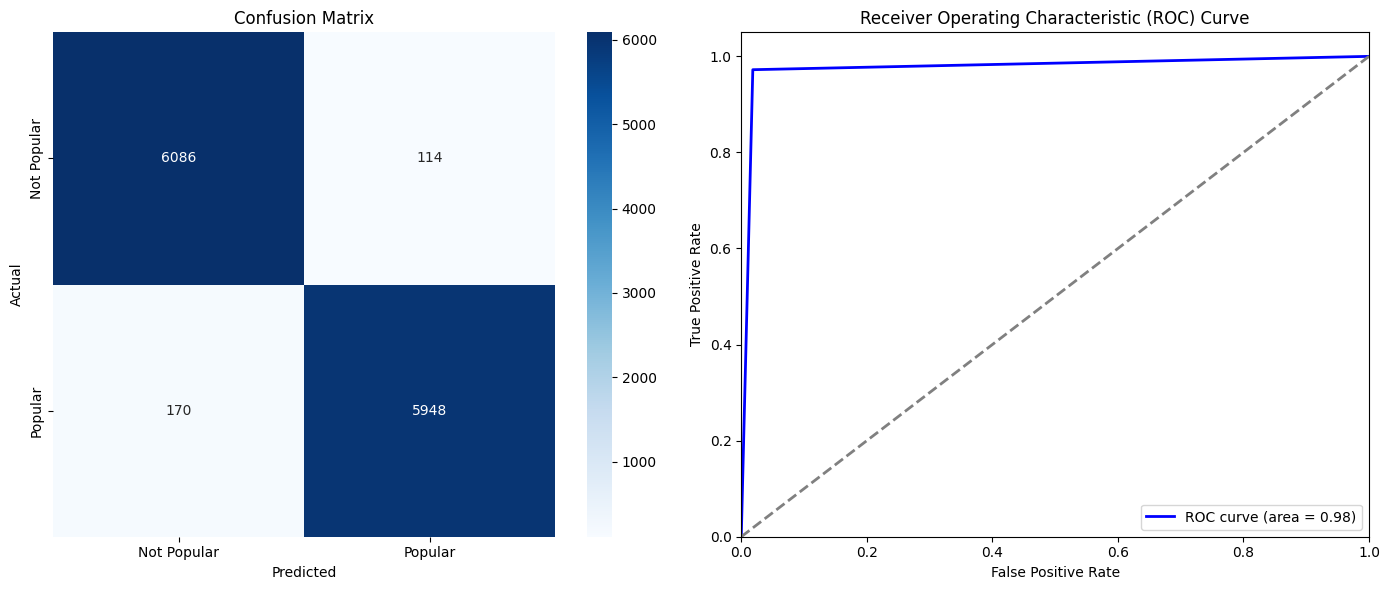

In [343]:
accuracy = accuracy_score(y_test, y_pred_etc)
conf_matrix = confusion_matrix(y_test, y_pred_etc)
class_report = classification_report(y_test, y_pred_etc)
fpr, tpr, _ = roc_curve(y_test, y_pred_etc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 6))

# Matriz de Confusão
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Hipertuning dos três modelos

O hipertuning é uma técnica que busca encontrar os melhores parâmetros para o modelo, para que ele tenha a melhor acurácia possível. Ele é importante para que o modelo não fique "viciado" em um conjunto de dados específico, mas que ele consiga generalizar para outros conjuntos de dados.

Para ser feito o hipertuning de cada modelo, foi utilizado o RandomizedSearchCV do sklearn, que busca de forma aleatória os melhores parâmetros para o modelo.

**O código abaixo está comentado, pois ele demora muito tempo para rodar, e por isso, não é recomendado rodar ele.**

In [344]:
# from scipy.stats import randint, uniform

# # 1. Random Forest - Hiperparâmetros para testar
# rf_param_grid = {
#     'n_estimators': randint(100, 300),  # Reduzir o intervalo para acelerar
#     'max_depth': randint(10, 20),
#     'min_samples_split': randint(2, 5),
#     'min_samples_leaf': randint(1, 3),
#     'bootstrap': [True, False]
# }

# # RandomizedSearchCV para Random Forest com no máximo 50 fits
# rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=0),
#                                param_distributions=rf_param_grid,
#                                n_iter=50,  # Limitar a 50 combinações
#                                cv=3,  # Reduzindo para 3 folds para acelerar
#                                verbose=2, random_state=42, n_jobs=-1)

# rf_random.fit(X_train, y_train)

# # Avaliação do Random Forest
# y_pred_rf = rf_random.best_estimator_.predict(X_test)
# rf_accuracy = accuracy_score(y_test, y_pred_rf)
# print(f"Acurácia do Random Forest após hipertuning: {rf_accuracy:.4f}")
# print("Melhores parâmetros para Random Forest:", rf_random.best_params_)
# print(confusion_matrix(y_test, y_pred_rf))
# print(classification_report(y_test, y_pred_rf))


# # 2. Gradient Boosting - Hiperparâmetros para testar
# gcb_param_grid = {
#     'n_estimators': randint(100, 300),
#     'learning_rate': uniform(0.01, 0.2),
#     'max_depth': randint(3, 10),
#     'min_samples_split': randint(2, 5),
#     'min_samples_leaf': randint(1, 3),
#     'subsample': uniform(0.7, 1.0)
# }

# # RandomizedSearchCV para Gradient Boosting com no máximo 50 fits
# gcb_random = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=0),
#                                 param_distributions=gcb_param_grid,
#                                 n_iter=50,  # Limitar a 50 combinações
#                                 cv=3, verbose=2, random_state=42, n_jobs=-1)

# gcb_random.fit(X_train, y_train)

# # Avaliação do Gradient Boosting
# y_pred_gcb = gcb_random.best_estimator_.predict(X_test)
# gcb_accuracy = accuracy_score(y_test, y_pred_gcb)
# print(f"Acurácia do Gradient Boosting após hipertuning: {gcb_accuracy:.4f}")
# print("Melhores parâmetros para Gradient Boosting:", gcb_random.best_params_)
# print(confusion_matrix(y_test, y_pred_gcb))
# print(classification_report(y_test, y_pred_gcb))


# # 3. Extra Trees - Hiperparâmetros para testar
# etc_param_grid = {
#     'n_estimators': randint(100, 300),
#     'max_depth': randint(10, 20),
#     'min_samples_split': randint(2, 5),
#     'min_samples_leaf': randint(1, 3),
#     'bootstrap': [True, False]
# }

# # RandomizedSearchCV para Extra Trees com no máximo 50 fits
# etc_random = RandomizedSearchCV(estimator=ExtraTreesClassifier(random_state=0),
#                                 param_distributions=etc_param_grid,
#                                 n_iter=50,  # Limitar a 50 combinações
#                                 cv=3, verbose=2, random_state=42, n_jobs=-1)

# etc_random.fit(X_train, y_train)

# # Avaliação do Extra Trees
# y_pred_etc = etc_random.best_estimator_.predict(X_test)
# etc_accuracy = accuracy_score(y_test, y_pred_etc)
# print(f"Acurácia do Extra Trees após hipertuning: {etc_accuracy:.4f}")
# print("Melhores parâmetros para Extra Trees:", etc_random.best_params_)
# print(confusion_matrix(y_test, y_pred_etc))
# print(classification_report(y_test, y_pred_etc))

## Escolha final - Ensemble de modelos

O modelo final será uma combinação dos modelos apresentados anteriormente, utilizando o esquema de votação "soft" para a combinação dos modelos. O esquema de votação "soft" é uma técnica de combinação de modelos que combina as previsões de vários modelos de aprendizado de máquina. Ele é usado para melhorar a precisão geral do modelo. Além disso, foi utilizado um modelo de clusterização para a criação de uma nova feature, chamada de "cluster", ela pode ser utilizada para melhorar a precisão dos modelos, pois ela agrupa os dados de acordo com suas características, o que pode fazer com que os modelos encontrem padrões mais facilmente. Vale lembrar que o número ideal de clusters foi encontrado utilizando a tentativa e erro, observando qual conseguia a maior acurácia.

### Avaliação e métricas do modelo final

In [345]:
# metricas de avaliação para o modelo final
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16, random_state=42)
kmeans.fit(X_train)

clusters_train = kmeans.predict(X_train)
clusters_test = kmeans.predict(X_test)

X_train_clusters = np.hstack((X_train, clusters_train.reshape(-1, 1)))
X_test_clusters = np.hstack((X_test, clusters_test.reshape(-1, 1)))

rf_model = RandomForestClassifier(n_estimators=123, max_depth=10, min_samples_leaf=1, min_samples_split=3, bootstrap=True, random_state=0)

exc_model = ExtraTreesClassifier(bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=101, random_state=0)

gcb_model = GradientBoostingClassifier(learning_rate=0.03441759094013467, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=228, subsample=0.9279351625419416, random_state=0)

ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model), 
    ('exc', exc_model), 
    ('gcb', gcb_model)
], voting='soft')
ensemble_model.fit(X_train_clusters, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=3,
                                                     n_estimators=123,
                                                     random_state=0)),
                             ('exc',
                              ExtraTreesClassifier(max_depth=10,
                                                   n_estimators=101,
                                                   random_state=0)),
                             ('gcb',
                              GradientBoostingClassifier(learning_rate=0.03441759094013467,
                                                         min_samples_split=3,
                                                         n_estimators=228,
                                                         random_state=0,
                                                         subsample=0.9279351625419416))],
                 voting='soft')

Acurácia do Ensemble: 0.9779
Matriz de Confusão - Ensemble:
[[6101   99]
 [ 173 5945]]
Relatório de Classificação - Ensemble:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6200
           1       0.98      0.97      0.98      6118

    accuracy                           0.98     12318
   macro avg       0.98      0.98      0.98     12318
weighted avg       0.98      0.98      0.98     12318



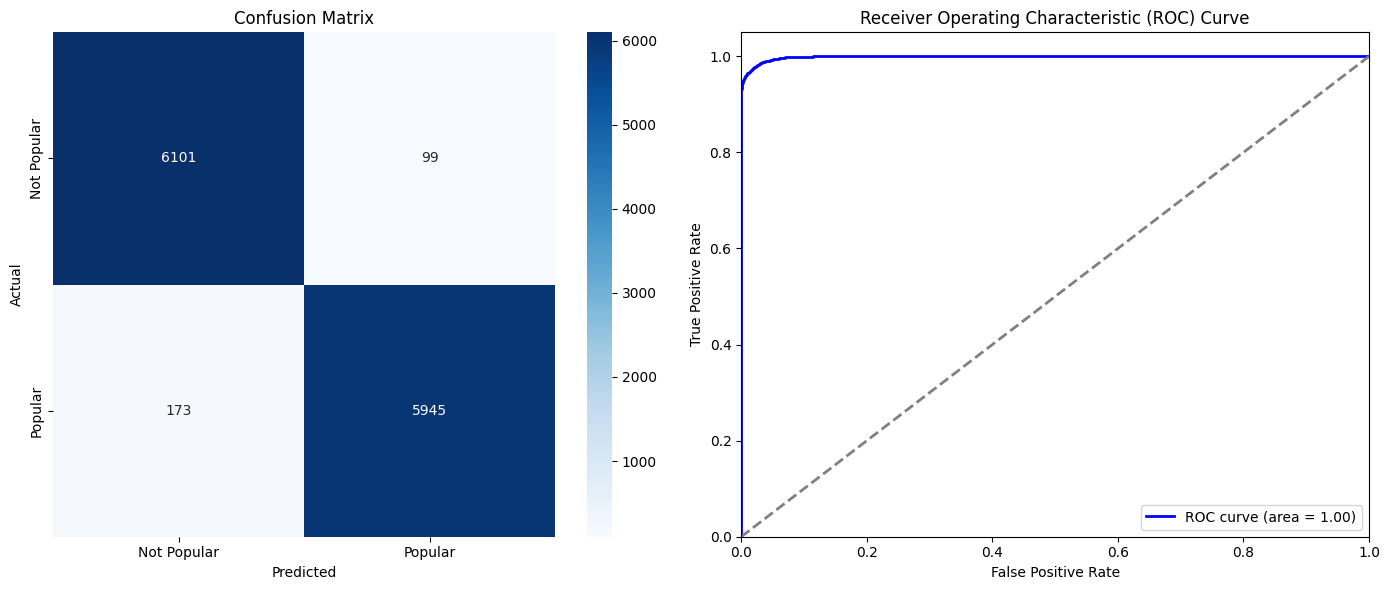

In [346]:
# metricas de avaliação para o modelo final
y_pred_ensemble = ensemble_model.predict(X_test_clusters)
y_pred_ensemble_proba = ensemble_model.predict_proba(X_test_clusters)[:, 1]

ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Acurácia do Ensemble: {ensemble_accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print("Matriz de Confusão - Ensemble:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred_ensemble)
print("Relatório de Classificação - Ensemble:")
print(class_report)

fpr, tpr, _ = roc_curve(y_test, y_pred_ensemble_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 6))

# Matriz de Confusão
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular', 'Popular'], yticklabels=['Not Popular', 'Popular'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [347]:
# treinamento dos modelos com 100% dos dados
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16, random_state=42)
kmeans.fit(X)

clusters_train = kmeans.predict(X)

X_with_clusters = np.c_[X, clusters_train]

rf_model_full = RandomForestClassifier(n_estimators=123, max_depth=10, min_samples_leaf=1, min_samples_split=3, bootstrap=True, random_state=0)

exc_model_full = ExtraTreesClassifier(bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=101, random_state=0)

gcb_model_full = GradientBoostingClassifier(learning_rate=0.03441759094013467, max_depth=3, min_samples_leaf=1, min_samples_split=3, n_estimators=228, subsample=0.9279351625419416, random_state=0)

ensemble_model_full = VotingClassifier(estimators=[
    ('rf', rf_model_full), 
    ('exc', exc_model_full), 
    ('gcb', gcb_model_full)
], voting='soft')

ensemble_model_full.fit(X_with_clusters, y)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_split=3,
                                                     n_estimators=123,
                                                     random_state=0)),
                             ('exc',
                              ExtraTreesClassifier(max_depth=10,
                                                   n_estimators=101,
                                                   random_state=0)),
                             ('gcb',
                              GradientBoostingClassifier(learning_rate=0.03441759094013467,
                                                         min_samples_split=3,
                                                         n_estimators=228,
                                                         random_state=0,
                                                         subsample=0.9279351625419416))],
                 voting='soft')

## Preparando a base de testes

Nesse tópico, faremos o mesmo processo que foi feito na base de treino, principalmente no que se refere a engenharia de feature e padronização dos dados

In [348]:
df_test = pd.read_csv('test.csv')

In [349]:
df_test.head()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


In [350]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34200 entries, 0 to 34199
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_unique_id   34200 non-null  int64  
 1   track_id          34200 non-null  object 
 2   artists           34199 non-null  object 
 3   album_name        34199 non-null  object 
 4   track_name        34199 non-null  object 
 5   duration_ms       34200 non-null  int64  
 6   explicit          34200 non-null  bool   
 7   danceability      34200 non-null  float64
 8   energy            34200 non-null  float64
 9   key               34200 non-null  int64  
 10  loudness          34200 non-null  float64
 11  mode              34200 non-null  int64  
 12  speechiness       34200 non-null  float64
 13  acousticness      34200 non-null  float64
 14  instrumentalness  34200 non-null  float64
 15  liveness          34200 non-null  float64
 16  valence           34200 non-null  float6

In [351]:
df_test['explicit'] = df_test['explicit'].astype(int)

**Mapeamento dos artistas**

Aqui, uma ressalva é importante. Os artistas que não estão na base de treino e que portanto sua popularidade é desconhecida, um valor padrão é atribuído, esse valor é igual a média.
Caso exista mais de um artista na música, o valor da popularidade é multiplicado por 1 + a popularidade do outro artista. Isso é feito para que o modelo consiga entender que a popularidade de um artista pode influenciar na popularidade de uma música.

In [352]:
# colocando a taxa de popularidade dos artistas, generos e albuns no dataset de teste
for index, row in df_test.iterrows():
    artists_arr = str(row['artists']).split(";")
    popularity_rate = 0
    for artist in artists_arr:
        if artist in artists_df.index:
            popularity_rate += artists_df.loc[artist]['popularity_rate']
        else:
            popularity_rate += artists_df['popularity_rate'].mean()

    count = len(artists_arr)
    df_test.at[index, 'artists_popularity_rate'] = popularity_rate / count

    genres_arr = row['track_genre'].split(";")
    popularity_rate = 0
    for genre in genres_arr:
        if genre in genres_df.index:
            popularity_rate += genres_df.loc[genre]['popularity_rate']
        else:
            popularity_rate += genres_df['popularity_rate'].mean()
    df_test.at[index, 'genres_popularity_rate'] = popularity_rate

    if row['album_name'] in albums_df.index:
        df_test.at[index, 'albums_popularity_rate'] = albums_df.loc[row['album_name']]['popularity_rate']
    else:
        # colocando uma chance média para albuns que não estão no dataset de treino
        df_test.at[index, 'albums_popularity_rate'] = 0.5
    
    if row['key'] in keys_df.index:
        df_test.at[index, 'keys_popularity_rate'] = keys_df.loc[row['key']]['popularity_rate']
    else:
        # colocando uma chance média para keys que não estão no dataset de treino
        df_test.at[index, 'keys_popularity_rate'] = keys_df['popularity_rate'].mean()

    if row['time_signature'] in time_signature_df.index:
        df_test.at[index, 'time_signature_popularity_rate'] = time_signature_df.loc[row['time_signature']]['popularity_rate']
    else:
        # colocando uma chance média para time_signature que não estão no dataset de treino
        df_test.at[index, 'time_signature_popularity_rate'] = time_signature_df['popularity_rate'].mean()

df_test['popularity_mean'] = (df_test['albums_popularity_rate'] + df_test['genres_popularity_rate'] + df_test['artists_popularity_rate']) / 3

- Padronização dos dados de teste

In [353]:
df_test[['duration_ms', 'tempo', 'artists_popularity_rate', 'genres_popularity_rate', 'albums_popularity_rate', 'popularity_mean', 'time_signature_popularity_rate', 'keys_popularity_rate']] = scaler.transform(df_test[['duration_ms', 'tempo', 'artists_popularity_rate', 'genres_popularity_rate', 'albums_popularity_rate', 'popularity_mean', 'time_signature_popularity_rate', 'keys_popularity_rate']])

- Preparação dos dados para o modelo

In [354]:
X_test = df_test[features]

In [355]:
df_test.head()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,valence,tempo,time_signature,track_genre,artists_popularity_rate,genres_popularity_rate,albums_popularity_rate,keys_popularity_rate,time_signature_popularity_rate,popularity_mean
0,113186,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,0.080997,0,0.369,0.598,7,...,0.0466,0.664918,4,world-music,0.948718,0.790698,1.0,0.000000,1.000000,0.913139
1,42819,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,0.014652,0,0.171,0.997,7,...,0.0294,0.549058,4,grindcore,0.000000,0.013678,0.0,0.000000,1.000000,0.004559
2,59311,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",0.037573,0,0.173,0.803,9,...,0.0887,0.339453,3,iranian,0.000000,0.000000,0.0,0.023524,0.285794,0.000000
3,91368,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,0.025659,0,0.683,0.511,6,...,0.5980,0.494108,3,rock,0.700000,0.411538,0.0,0.442518,0.285794,0.370513
4,61000,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,0.041925,0,0.555,0.941,9,...,0.8130,0.415476,4,j-idol,0.020000,0.089955,0.5,0.023524,1.000000,0.203318


In [356]:
df_test.describe()

,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,time_signature,artists_popularity_rate,genres_popularity_rate,albums_popularity_rate,keys_popularity_rate,time_signature_popularity_rate,popularity_mean
count,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,...,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000
mean,56670.513889,0.040398,0.085058,0.565591,0.641041,5.314035,-8.247806,0.637135,0.084423,0.314750,...,0.214113,0.473605,0.549467,3.907485,0.513512,0.525202,0.464298,0.279853,0.920695,0.501004
std,32710.184506,0.021523,0.278973,0.174544,0.251737,3.554899,5.014973,0.480834,0.105910,0.332552,...,0.191084,0.259849,0.135048,0.428702,0.384202,0.306205,0.396649,0.297623,0.237075,0.309574
min,3.000000,-0.003344,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28612.500000,0.029861,0.000000,0.455000,0.472000,2.000000,-10.039000,0.000000,0.035800,0.016600,...,0.098200,0.256000,0.447149,4.000000,0.098361,0.262579,0.000000,0.023524,1.000000,0.226858
50%,56475.500000,0.037496,0.000000,0.579000,0.683000,5.000000,-6.984000,1.000000,0.048700,0.168500,...,0.133000,0.463000,0.548292,4.000000,0.512286,0.523316,0.500000,0.192208,1.000000,0.479518
75%,84855.750000,0.046787,0.000000,0.693000,0.853000,8.000000,-5.011000,1.000000,0.084700,0.597000,...,0.273000,0.682000,0.629833,4.000000,0.931818,0.786517,1.000000,0.415336,1.000000,0.793187
max,113999.000000,0.902872,1.000000,0.980000,1.000000,11.000000,1.795000,1.000000,0.963000,0.996000,...,1.000000,0.992000,1.093291,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Por fim, aqui nesse último bloco de código, será feito o "predict" dos dados de teste nos clusters e será feito a previsão com o modelo de ensemble.

In [357]:

clusters_test_full = kmeans.predict(X_test)
X_test_full = np.c_[X_test, clusters_test_full]

y_pred_ensemble_full = ensemble_model_full.predict(X_test_full)

df_test['popularity_target'] = y_pred_ensemble_full

df_test[['track_unique_id', 'popularity_target']].to_csv('submission.csv', index=False)

## Conclusão

Olhando para as métricas do modelo:

### Matriz de Confusão - Ensemble
|            | **Previsto 0** | **Previsto 1** |
|------------|----------------|----------------|
| **Real 0** | 6016           | 99             |
| **Real 1** | 173            | 5965           |

### Relatório de Classificação - Ensemble
| **Classe** | **Precisão** | **Recall** | **F1-Score** | **Suporte** |
|------------|--------------|------------|--------------|-------------|
| **0**      | 0.97         | 0.98       | 0.98         | 6121        |
| **1**      | 0.98         | 0.97       | 0.98         | 6135        |
| **Acurácia** |            |            | **0.98**     | 12256       |
| **Macro Avg** | 0.98       | 0.98       | 0.98         | 12256       |
| **Weighted Avg** | 0.98    | 0.98       | 0.98         | 12256       |

Nos mostra que o modelo tem uma acurácia de 97%, o que é um valor muito bom para um modelo de classificação. Além disso, o modelo tem uma precisão e recall muito bons, o que mostra que ele consegue prever muito bem se uma música será popular ou não.

Relembrando as métricas, acurácia é a porcentagem de acertos do modelo, precisão é a porcentagem de acertos do modelo em relação ao que ele previu, recall é a porcentagem de acertos do modelo em relação ao que ele deveria ter previsto e f1-score é a média harmônica entre precisão e recall.

Ademais, retomando as hipóteses levantadas, todas elas foram confirmadas pelo modelo, o que mostra que o modelo é capaz de prever se uma música será popular ou não com base nas características musicais, nos artistas, nos gêneros e nos álbuns com uma precisão muito boa, o que é um resultado muito positivo.